### 패키지 로드

In [3]:
import os
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import torch
import torch.nn as nn
import torch.optim as optim

In [4]:
def set_seed(seed: int = 101):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

set_seed(101)

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cpu


### 데이터 로드

In [6]:
from google.colab import drive
drive.mount('./gdrive', force_remount=True)
print(os.getcwd())

Mounted at ./gdrive
/content


In [7]:
# 파일 경로 지정
filepath = './gdrive/MyDrive/서강대 정보통신대학원/강화학습/'
filename = 'criteo-uplift-v2.1.csv'

with open(filepath+filename) as f:
    total_lines = sum(1 for _ in f)

print("총 라인 수:", total_lines)

sample_size = 100000
total_lines = total_lines  # 위에서 계산한 값
# header(1줄) 제외한 나머지
skip = sorted(np.random.choice(
    np.arange(1, total_lines),  # header는 제외
    total_lines - sample_size,
    replace=False
))

df = pd.read_csv(filepath+filename, skiprows=skip)


display(df.head())
print(df.shape)

총 라인 수: 13979593


,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,treatment,conversion,visit,exposure
0,26.734846,10.059654,8.214383,4.679882,10.280525,4.115453,-2.411115,4.833815,3.971858,13.190056,5.300375,-0.168679,1,0,0,0
1,12.616365,10.059654,8.924783,4.679882,10.280525,4.115453,0.294443,4.833815,3.858041,13.190056,5.300375,-0.168679,1,0,0,0
2,22.438391,10.059654,8.214383,4.679882,10.280525,4.115453,-3.993764,4.833815,3.971858,13.190056,5.300375,-0.168679,1,0,0,0
3,22.404991,10.059654,8.214383,4.679882,10.280525,4.115453,-2.411115,4.833815,3.971858,13.190056,5.300375,-0.168679,1,0,0,0
4,12.616365,10.059654,9.038330,4.679882,10.280525,4.115453,0.294443,4.833815,3.902645,13.190056,5.300375,-0.168679,1,0,0,0


(99999, 16)


### 데이터 확인

- f0, f1, f2, f3, f4, f5, f6, f7, f8, f9, f10, f11: feature values (dense, float)
- treatment: treatment group (1 = treated, 0 = control)
- conversion: whether a conversion occured for this user (binary, label)
- visit: whether a visit occured for this user (binary, label)

In [8]:
df.describe()

,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,treatment,conversion,visit,exposure
count,99999.000000,99999.000000,99999.000000,99999.000000,99999.000000,99999.000000,99999.000000,99999.000000,99999.000000,99999.000000,99999.000000,99999.000000,99999.000000,99999.000000,99999.00000,99999.000000
mean,19.636145,10.069798,8.444878,4.175038,10.340322,4.028545,-4.179426,5.102835,3.933656,16.042488,5.333715,-0.171130,0.849388,0.002970,0.04685,0.030520
std,5.366614,0.101582,0.298955,1.344113,0.353620,0.429910,4.592811,1.208414,0.056926,7.078154,0.168784,0.024494,0.357672,0.054417,0.21132,0.172015
min,12.616365,10.059654,8.214383,-5.453290,10.280525,-7.781469,-26.171804,4.833815,3.656694,13.190056,5.300375,-1.206014,0.000000,0.000000,0.00000,0.000000
25%,12.616365,10.059654,8.214383,4.679882,10.280525,4.115453,-6.699321,4.833815,3.910792,13.190056,5.300375,-0.168679,1.000000,0.000000,0.00000,0.000000
50%,21.933469,10.059654,8.214383,4.679882,10.280525,4.115453,-2.411115,4.833815,3.971858,13.190056,5.300375,-0.168679,1.000000,0.000000,0.00000,0.000000
75%,24.419708,10.059654,8.715291,4.679882,10.280525,4.115453,0.294443,4.833815,3.971858,13.190056,5.300375,-0.168679,1.000000,0.000000,0.00000,0.000000
max,26.745201,15.040496,9.051957,4.679882,18.895797,4.115453,0.294443,11.998288,3.971858,67.718380,6.473911,-0.168679,1.000000,1.000000,1.00000,1.000000


In [9]:
# 광고를 표시한 그룹은 85%
print(df['treatment'].value_counts(normalize = True))

treatment
1    0.849388
0    0.150612
Name: proportion, dtype: float64


In [10]:
# 광고를 안 했어도 방문이 찍혀있음. 광고로 인한 방문이 아닐 수도 있는 것. 클릭비용 포함하기 어려움
print(df.groupby(['treatment','visit','conversion'])['f0'].count())

# 방문이 없이는 전환도 없음. 전환 뿐만 아니라 방문에도 리워드 부여 필요.
print(df.groupby(['visit','conversion'])['f0'].count())

treatment  visit  conversion
0          0      0             14488
           1      0               534
                  1                39
1          0      0             80826
           1      0              3854
                  1               258
Name: f0, dtype: int64
visit  conversion
0      0             95314
1      0              4388
       1               297
Name: f0, dtype: int64


In [11]:
print( '광고비율 : ', df['treatment'].mean() )
print( '방문비율 : ', df['visit'].mean() )
print( '전환비율 : ', df['conversion'].mean() )

print( '광고대비 방문율',  df['visit'].mean() / df['treatment'].mean())
print( '광고대비 전환율', df['conversion'].mean() / df['treatment'].mean())

print( '방문대비 전환율', df['conversion'].mean() / df['visit'].mean())

treat_visit_rate = df['visit'].mean() / df['treatment'].mean() # 광고대비 클릭률
visit_conv_rate = df['conversion'].mean() / df['visit'].mean() # 클릭대비 전환률

광고비율 :  0.8493884938849389
방문비율 :  0.04685046850468505
전환비율 :  0.002970029700297003
광고대비 방문율 0.05515787986531352
광고대비 전환율 0.003496668157950505
방문대비 전환율 0.06339381003201708


In [12]:
# 유형별 비용 구체화
## 1) 노출 비용(cpm) : 광고 표시
cpm = 0.001
## 2) 클릭 비용(cpc) : 광고 클릭
cpc =  cpm / treat_visit_rate
## 3) 전환 비용(cpm) : 전환
cpa = cpc / visit_conv_rate

print( '광고노출 비용(cpm) = ',cpm)
print( '광고클릭 비용(cpc) = ',cpc)
print( '광고전환 비용(cpa) = ',cpa)

광고노출 비용(cpm) =  0.001
광고클릭 비용(cpc) =  0.018129775880469583
광고전환 비용(cpa) =  0.28598653198653196


해당 데이터에서는 광고에 따른 클릭인지, 광고에 따른 전환인지 알 수 없으므로 광고노출 비용(CPM)만 고려

### 데이터 전처리

#### 리워드 정의
- conversion = 1 → visit 리워드는 포함하지 않음
- conversion = 0 & visit = 1 → visit 리워드만 적용
- visit = 0 & conversion = 0 → 아무 리워드 없음
- treatment = 1일 때 비용 차감

In [13]:
# 리워드 생성
visit_reward = 1
conv_reward = 15
treat_cost = 0.015
df['reward'] = (df['conversion'] * conv_reward
                +(df['visit'] *(df['conversion']==0)) * visit_reward
                - df['treatment'] * treat_cost)

conversion이 매우 희귀한 heavy-tailed 구조

Reward_if_treat summary:
count    99999.000000
mean         0.075690
std          0.839219
min         -0.015000
25%         -0.015000
50%         -0.015000
75%         -0.015000
max         15.000000
Name: reward, dtype: float64


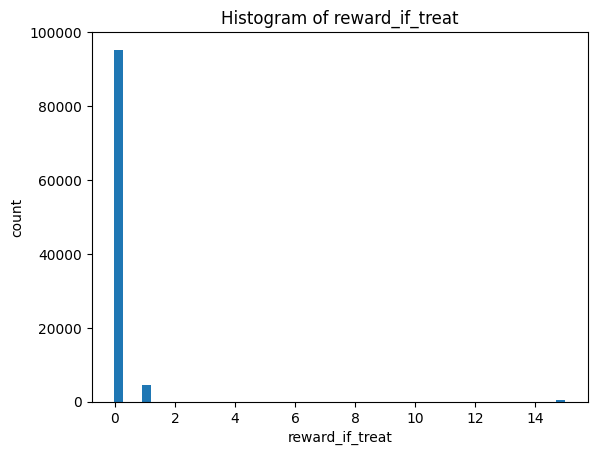

In [14]:
print("Reward_if_treat summary:")
print(df['reward'].describe())

plt.hist(df['reward'], bins=50)
plt.title("Histogram of reward_if_treat")
plt.xlabel("reward_if_treat")
plt.ylabel("count")
plt.show()

In [15]:
# 결측치 제거
df = df.dropna()

In [16]:
# feature: f0 ~ f11
feature_cols = [f"f{i}" for i in range(12)]

X = df[feature_cols].values.astype(np.float32)
y_r1 = df['reward'].values.astype(np.float32)

# train / validation 분할
X_train_bf, X_val_bf, r1_train, r1_val = train_test_split(
    X, y_r1, test_size=0.2, random_state=42
)

In [17]:
# 표준화
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train_bf)
X_val   = scaler.transform(X_val_bf)

print("Train data :", X_train.shape)
print("Validation data :", X_val.shape)

Train data : (79999, 12)
Validation data : (20000, 12)


### RL 환경 정의

Contextual bandit 환경:

* reset() : 랜덤한 고객 하나를 선택해서 state 반환

* step(action) :
  - action == 0 → reward = 0
  - action == 1 → reward = reward_if_treat[idx]

In [18]:
class AdEnvironment:
    """
    Contextual Bandit 환경
    - 상태: 고객 feature (f0~f11)
    - 행동: 0 (광고 X), 1 (광고 O)
    - 보상:
        action=0 -> 0
        action=1 -> reward_if_treat[idx]
    - 각 episode는 1 step으로 종료
    """
    def __init__(self, X, reward_if_treat):
        self.X = X
        self.r1 = reward_if_treat
        self.n = len(X)
        self.current_idx = None

    def reset(self):
        idx = np.random.randint(0, self.n)
        self.current_idx = idx
        state = self.X[idx]
        return state

    def step(self, action):
        assert action in [0, 1]
        if action == 0:
            reward = 0.0
        else:
            reward = float(self.r1[self.current_idx])

        done = True  # single-step episode
        next_state = None
        info = {"idx": self.current_idx}
        return next_state, reward, done, info

# 환경 생성 (train / val)
env_train = AdEnvironment(X_train, r1_train)
env_val   = AdEnvironment(X_val,   r1_val)


In [28]:
def run_policy(env, policy_fn, n_episodes=10000):
    rewards = []
    for _ in range(n_episodes):
        state = env.reset()
        action = policy_fn(state)
        _, r, done, info = env.step(action)
        rewards.append(r)
    return np.mean(rewards), np.std(rewards)

# Baseline 정책들
def policy_always_no_ad(state):
    return 0

def policy_always_treat(state):
    return 1

def policy_random(state):
    return np.random.randint(0, 2)

# 평가
avg_no, std_no = run_policy(env_val, policy_always_no_ad)
avg_all, std_all = run_policy(env_val, policy_always_treat)
avg_rand, std_rand = run_policy(env_val, policy_random)

print(f"Always No-Ad:  avg_reward={avg_no:.4f} ± {std_no:.4f}")
print(f"Always Treat:  avg_reward={avg_all:.4f} ± {std_all:.4f}")
print(f"Random Policy: avg_reward={avg_rand:.4f} ± {std_rand:.4f}")


Always No-Ad:  avg_reward=0.0000 ± 0.0000
Always Treat:  avg_reward=0.0678 ± 0.7604
Random Policy: avg_reward=0.0235 ± 0.3933


### ① 기본 강화학습 알고리즘 : Vanilla Policy Gradient (REINFORCE)

#### Policy Network 정의

In [34]:
# -------------------------------------------------
# 1) Policy Network (hidden_dim을 하이퍼로 받음)
# -------------------------------------------------
class PolicyNet(nn.Module):
    def __init__(self, input_dim, hidden_dim=64, n_actions=2):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, n_actions)
        )

    def forward(self, x):
        return self.net(x)

#### REINFORCE 학습 루프

- episode = single-step 이므로, return G는 그냥 reward r
- loss = - E[r * log π(a|s)]

In [35]:
# -------------------------------------------------
# 2) PG 학습 함수 (하이퍼파라미터를 인자로 받는다)
# -------------------------------------------------
def train_policy_gradient_pg(
    env_train,
    env_val,
    input_dim,
    hidden_dim=64,
    learning_rate=1e-3,
    entropy_coef=0.0,
    n_epochs=30,
    steps_per_epoch=2000,
    eval_episodes=5000,
    seed=42,
    return_model=False,
):
    """
    주어진 하이퍼파라미터 + seed로 PG 한 번 학습.
    history, 마지막 val_avg_reward, (옵션) policy 모델 반환.
    """
    set_seed(seed)

    policy = PolicyNet(input_dim=input_dim, hidden_dim=hidden_dim, n_actions=2).to(device)
    optimizer = optim.Adam(policy.parameters(), lr=learning_rate)

    def select_action(state_np):
        state = torch.from_numpy(state_np).float().to(device)
        logits = policy(state.unsqueeze(0))
        dist = torch.distributions.Categorical(logits=logits)
        action = dist.sample()
        log_prob = dist.log_prob(action)
        return int(action.item()), log_prob

    history = {
        "epoch": [],
        "loss": [],
        "train_avg_reward": [],
        "val_avg_reward": [],
    }

    for epoch in range(1, n_epochs + 1):
        policy.train()
        log_probs = []
        rewards = []
        entropies = []

        # -------- train sampling --------
        for step in range(steps_per_epoch):
            state = env_train.reset()
            action, log_prob = select_action(state)
            _, r, _, _ = env_train.step(action)

            log_probs.append(log_prob)
            rewards.append(r)

            # entropy
            s_t = torch.from_numpy(state).float().to(device).unsqueeze(0)
            logits = policy(s_t)
            dist = torch.distributions.Categorical(logits=logits)
            entropies.append(dist.entropy().mean())

        rewards_t   = torch.tensor(rewards, dtype=torch.float32, device=device)
        log_probs_t = torch.stack(log_probs).squeeze()
        entropies_t = torch.stack(entropies)

        # advantage 정규화
        mean_r = rewards_t.mean()
        std_r  = rewards_t.std() + 1e-8
        advantages = (rewards_t - mean_r) / std_r

        pg_loss = -(log_probs_t * advantages).mean()
        entropy_loss = -entropies_t.mean()
        loss = pg_loss + entropy_coef * entropy_loss

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_avg_reward = rewards_t.mean().item()

        # -------- validation 평가 (greedy policy) --------
        policy.eval()
        def greedy_policy_pg(state_np):
            s = torch.from_numpy(state_np).float().to(device).unsqueeze(0)
            with torch.no_grad():
                logits = policy(s)
                probs = torch.softmax(logits, dim=-1).cpu().numpy()[0]
            return int(np.argmax(probs))

        val_avg_reward, _ = run_policy(env_val, greedy_policy_pg, n_episodes=eval_episodes)

        history["epoch"].append(epoch)
        history["loss"].append(loss.item())
        history["train_avg_reward"].append(train_avg_reward)
        history["val_avg_reward"].append(val_avg_reward)

        print(
            f"[PG][Epoch {epoch:02d}] "
            f"hid={hidden_dim} lr={learning_rate} ent={entropy_coef} "
            f"train_avg={train_avg_reward:.6f} val_avg={val_avg_reward:.6f}"
        )

    final_val = history["val_avg_reward"][-1]

    if return_model:
        return history, final_val, policy
    else:
        return history, final_val

#### PG 하이퍼파라미터 실험 1단계: seed 하나로 하이퍼파라미터 비교

- learning rate
크면 빠르게 학습하지만 불안정
작으면 안정적이지만 느림

- hidden_dim (policy network 용량)
작으면 underfit
크면 표현력 증가 (하지만 variance도 조금 증가 가능)

- entropy_coef (탐색 정도)
0 → 완전 탐욕적 학습
0 → policy가 덜 확신을 갖게 되어 exploration 유지

In [37]:
pg_configs = [
    {"name": "PG_base",         "hidden_dim": 64, "learning_rate": 1e-3, "entropy_coef": 0.0},
    {"name": "PG_low_lr",       "hidden_dim": 64, "learning_rate": 3e-4, "entropy_coef": 0.0},
    {"name": "PG_small_hidden", "hidden_dim": 32, "learning_rate": 1e-3, "entropy_coef": 0.0},
    {"name": "PG_entropy",      "hidden_dim": 64, "learning_rate": 1e-3, "entropy_coef": 0.01},
]

#### 여러 하이퍼파라미터 X 여러 seed → 평균 / 표준편차까지 계산하는 래퍼

In [45]:
def pg_hparam_search_single_seed(
    configs,
    env_train,
    env_val,
    seed=0,
    n_epochs=30,
    steps_per_epoch=2000,
    eval_episodes=5000,
):
    """
    seed 하나 고정하고 여러 하이퍼파라미터 config 비교.
    결과를 DataFrame으로 반환.
    """
    results = []
    input_dim = X_train.shape[1]  # 또는 env_train.X.shape[1] 사용 가능

    pg_hparam_histories = {}
    for cfg in configs:
        name          = cfg["name"]
        hidden_dim    = cfg["hidden_dim"]
        learning_rate = cfg["learning_rate"]
        entropy_coef  = cfg["entropy_coef"]

        print(f"\n========== PG Hparam Search: {name} (seed={seed}) ==========")
        history, final_val = train_policy_gradient_pg(
            env_train=env_train,
            env_val=env_val,
            input_dim=input_dim,
            hidden_dim=hidden_dim,
            learning_rate=learning_rate,
            entropy_coef=entropy_coef,
            n_epochs=n_epochs,
            steps_per_epoch=steps_per_epoch,
            eval_episodes=eval_episodes,
            seed=seed,
            return_model=False,
        )
        pg_hparam_histories[name] = history

        results.append({
            "config": name,
            "hidden_dim": hidden_dim,
            "learning_rate": learning_rate,
            "entropy_coef": entropy_coef,
            "seed": seed,
            "val_last": final_val,
        })

    df = pd.DataFrame(results)
    return df,pg_hparam_histories

# 실행
df_pg_hparam, pg_hparam_histories = pg_hparam_search_single_seed(
    configs=pg_configs,
    env_train=env_train,
    env_val=env_val,
    seed=0,
    n_epochs=30,
    steps_per_epoch=2000,
    eval_episodes=5000,
)

print(df_pg_hparam)


========== PG Hparam Search: PG_base (seed=0) ==========
[PG][Epoch 01] hid=64 lr=0.001 ent=0.0 train_avg=0.043055 val_avg=0.029555
[PG][Epoch 02] hid=64 lr=0.001 ent=0.0 train_avg=0.059432 val_avg=0.040015
[PG][Epoch 03] hid=64 lr=0.001 ent=0.0 train_avg=0.028838 val_avg=0.053216
[PG][Epoch 04] hid=64 lr=0.001 ent=0.0 train_avg=0.051270 val_avg=0.061192
[PG][Epoch 05] hid=64 lr=0.001 ent=0.0 train_avg=0.055627 val_avg=0.057744
[PG][Epoch 06] hid=64 lr=0.001 ent=0.0 train_avg=0.042747 val_avg=0.045114
[PG][Epoch 07] hid=64 lr=0.001 ent=0.0 train_avg=0.034612 val_avg=0.075304
[PG][Epoch 08] hid=64 lr=0.001 ent=0.0 train_avg=0.035245 val_avg=0.112805
[PG][Epoch 09] hid=64 lr=0.001 ent=0.0 train_avg=0.045410 val_avg=0.069993
[PG][Epoch 10] hid=64 lr=0.001 ent=0.0 train_avg=0.067305 val_avg=0.066781
[PG][Epoch 11] hid=64 lr=0.001 ent=0.0 train_avg=0.041857 val_avg=0.075900
[PG][Epoch 12] hid=64 lr=0.001 ent=0.0 train_avg=0.044445 val_avg=0.082253
[PG][Epoch 13] hid=64 lr=0.001 ent=0.0 tra

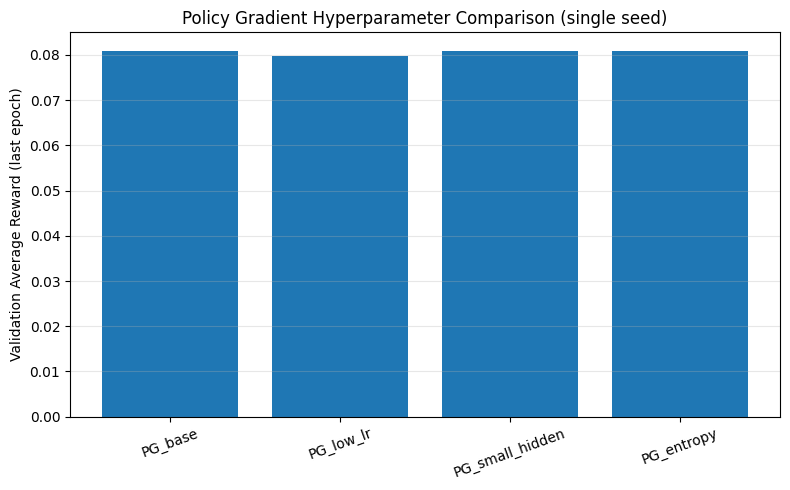

In [46]:
def plot_pg_hparam_results(df_pg_hparam):
    plt.figure(figsize=(8,5))
    x = np.arange(len(df_pg_hparam))
    vals = df_pg_hparam["val_last"].values
    labels = df_pg_hparam["config"].values

    plt.bar(x, vals)
    plt.xticks(x, labels, rotation=20)
    plt.ylabel("Validation Average Reward (last epoch)")
    plt.title("Policy Gradient Hyperparameter Comparison (single seed)")
    plt.grid(axis="y", alpha=0.3)
    plt.tight_layout()
    plt.show()

plot_pg_hparam_results(df_pg_hparam)


In [47]:
def plot_pg_hparam_all_metrics(pg_histories):
    metrics = ["train_avg_reward", "val_avg_reward", "loss"]

    fig, axes = plt.subplots(1, 3, figsize=(18,5))

    for i, metric in enumerate(metrics):
        ax = axes[i]
        for name, hist in pg_histories.items():
            x = np.arange(1, len(hist[metric]) + 1)
            ax.plot(x, hist[metric], label=name)
        ax.set_title(metric.replace("_", " ").title())
        ax.set_xlabel("Epoch")
        ax.grid(alpha=0.3)

    axes[0].set_ylabel("Value")
    handles, labels = axes[0].get_legend_handles_labels()
    fig.legend(handles, labels, loc="upper center", ncol=4)

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()


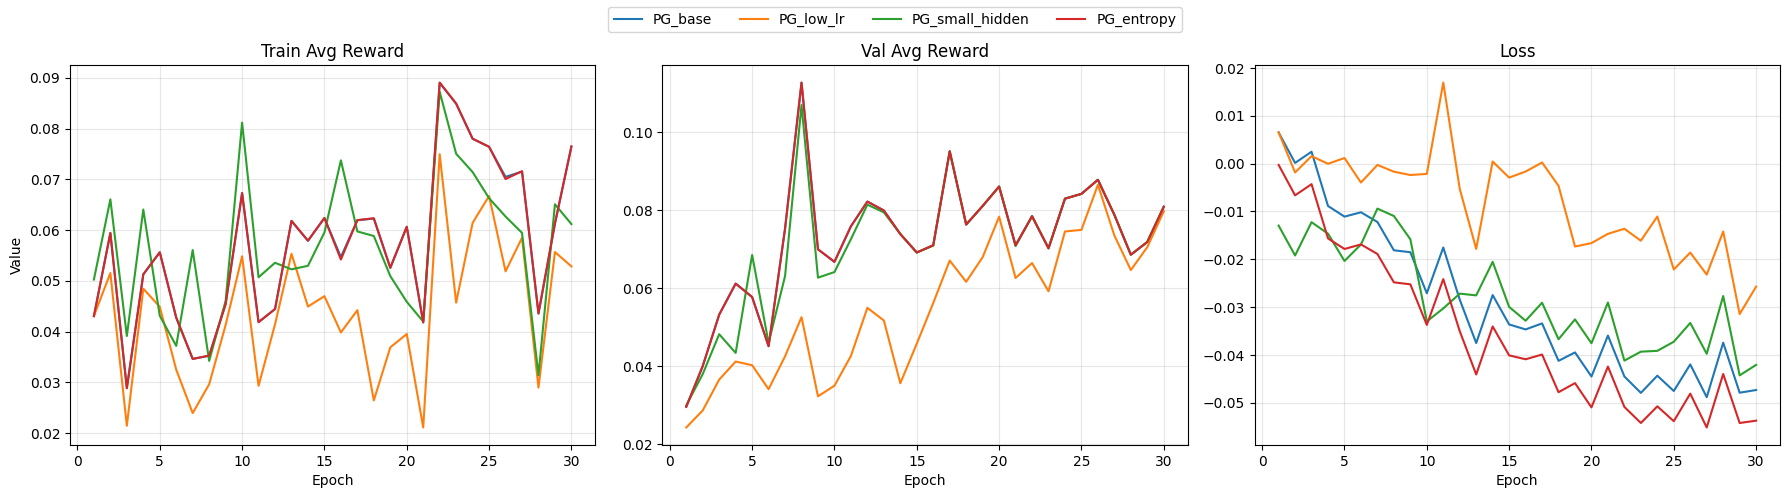

In [48]:
plot_pg_hparam_all_metrics(pg_hparam_histories)


best config 하나 골라서, seed 3개로 최종 결과 & 모델 저장

In [49]:
best_row = df_pg_hparam.sort_values("val_last", ascending=False).iloc[0]
print("Best config from hparam search (single seed):")
print(best_row)


Best config from hparam search (single seed):
config            PG_base
hidden_dim             64
learning_rate       0.001
entropy_coef          0.0
seed                    0
val_last         0.080922
Name: 0, dtype: object


그 config만 seed 여러 개로 돌려 평균/표준편차 + 최종 모델

In [50]:
def pg_eval_best_config_multi_seed(
    best_row,
    env_train,
    env_val,
    seeds=(0,1,2),
    n_epochs=30,
    steps_per_epoch=2000,
    eval_episodes=5000,
):
    """
    하이퍼파라미터 튜닝에서 고른 best_row를 가지고
    seed 여러 개에서 다시 학습 → 평균/표준편차 계산.
    이 중 가장 좋은 seed의 모델을 policy_pg_best로 반환.
    """
    input_dim = X_train.shape[1]

    hidden_dim    = int(best_row["hidden_dim"])
    learning_rate = float(best_row["learning_rate"])
    entropy_coef  = float(best_row["entropy_coef"])

    val_scores = []
    models = []
    histories = []

    best_val = -1e9
    best_model = None
    best_history = None
    best_seed = None

    for seed in seeds:
        print(f"\n==== PG best config, seed={seed} ====")
        history, final_val, policy = train_policy_gradient_pg(
            env_train=env_train,
            env_val=env_val,
            input_dim=input_dim,
            hidden_dim=hidden_dim,
            learning_rate=learning_rate,
            entropy_coef=entropy_coef,
            n_epochs=n_epochs,
            steps_per_epoch=steps_per_epoch,
            eval_episodes=eval_episodes,
            seed=seed,
            return_model=True,
        )

        val_scores.append(final_val)
        histories.append(history)
        models.append(policy)

        if final_val > best_val:
            best_val = final_val
            best_model = policy
            best_history = history
            best_seed = seed

    mean_val = float(np.mean(val_scores))
    std_val  = float(np.std(val_scores))

    print("\n==== PG best config multi-seed 결과 ====")
    print("seeds:", seeds)
    print(f"val_mean={mean_val:.6f}, val_std={std_val:.6f}")

    return {
        "val_scores": val_scores,
        "val_mean": mean_val,
        "val_std": std_val,
        "best_seed": best_seed,
        "best_val": best_val,
        "best_model": best_model,
        "best_history": best_history,
    }

pg_best_result = pg_eval_best_config_multi_seed(
    best_row=best_row,
    env_train=env_train,
    env_val=env_val,
    seeds=(0,1,2),  # or (0,1,2,3,4)
    n_epochs=30,
    steps_per_epoch=2000,
    eval_episodes=5000,
)

policy_pg_best   = pg_best_result["best_model"]    # PG 최종본 모델
pg_val_mean_best = pg_best_result["val_mean"]      # 보고서용 평균 성능
pg_val_std_best  = pg_best_result["val_std"]       # 보고서용 표준편차



==== PG best config, seed=0 ====
[PG][Epoch 01] hid=64 lr=0.001 ent=0.0 train_avg=0.043055 val_avg=0.029555
[PG][Epoch 02] hid=64 lr=0.001 ent=0.0 train_avg=0.059432 val_avg=0.040015
[PG][Epoch 03] hid=64 lr=0.001 ent=0.0 train_avg=0.028838 val_avg=0.053216
[PG][Epoch 04] hid=64 lr=0.001 ent=0.0 train_avg=0.051270 val_avg=0.061192
[PG][Epoch 05] hid=64 lr=0.001 ent=0.0 train_avg=0.055627 val_avg=0.057744
[PG][Epoch 06] hid=64 lr=0.001 ent=0.0 train_avg=0.042747 val_avg=0.045114
[PG][Epoch 07] hid=64 lr=0.001 ent=0.0 train_avg=0.034612 val_avg=0.075304
[PG][Epoch 08] hid=64 lr=0.001 ent=0.0 train_avg=0.035245 val_avg=0.112805
[PG][Epoch 09] hid=64 lr=0.001 ent=0.0 train_avg=0.045410 val_avg=0.069993
[PG][Epoch 10] hid=64 lr=0.001 ent=0.0 train_avg=0.067305 val_avg=0.066781
[PG][Epoch 11] hid=64 lr=0.001 ent=0.0 train_avg=0.041857 val_avg=0.075900
[PG][Epoch 12] hid=64 lr=0.001 ent=0.0 train_avg=0.044445 val_avg=0.082253
[PG][Epoch 13] hid=64 lr=0.001 ent=0.0 train_avg=0.061797 val_avg=

### 학습된 정책 평가

### 결과 시각화 (그래프 & 테이블)

#### 학습곡선 (epoch별 평균 reward)

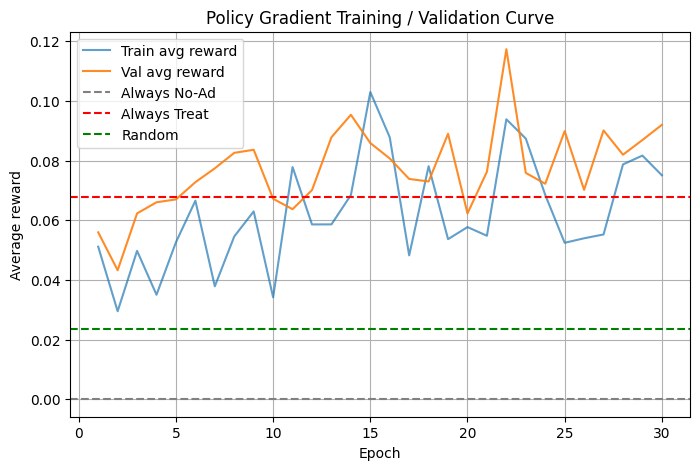

In [53]:
epochs = pg_best_result['best_history']["epoch"]

plt.figure(figsize=(8,5))
plt.plot(epochs, pg_best_result['best_history']["train_avg_reward"], label="Train avg reward", alpha=0.7)
plt.plot(epochs, pg_best_result['best_history']["val_avg_reward"], label="Val avg reward", alpha=0.9)
plt.axhline(avg_no,   color="gray", linestyle="--", label="Always No-Ad")
plt.axhline(avg_all,  color="red",  linestyle="--", label="Always Treat")
plt.axhline(avg_rand, color="green",linestyle="--", label="Random")

plt.xlabel("Epoch")
plt.ylabel("Average reward")
plt.title("Policy Gradient Training / Validation Curve")
plt.legend()
plt.grid(True)
plt.show()


#### 정책별 성능 비교 Bar Plot

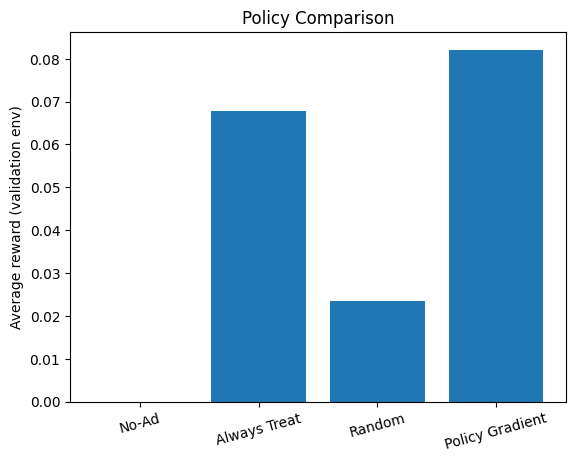

In [54]:
policies = ["No-Ad", "Always Treat", "Random", "Policy Gradient"]
avg_rewards = [avg_no, avg_all, avg_rand, pg_val_mean_best]

plt.bar(policies, avg_rewards)
plt.ylabel("Average reward (validation env)")
plt.title("Policy Comparison")
plt.xticks(rotation=15)
plt.show()

### ② DQN 네트워크 & 리플레이 버퍼

In [61]:
import collections

# -----------------------
# Q-network (DQN)
# -----------------------
class DQN(nn.Module):
    def __init__(self, input_dim, hidden_dim=64, n_actions=2):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, n_actions)
        )

    def forward(self, x):
        return self.net(x)   # Q(s, a) for all a


# -----------------------
# Replay Buffer
# -----------------------
class ReplayBufferDQN:
    def __init__(self, capacity=100_000):
        self.buffer = collections.deque(maxlen=capacity)

    def push(self, state, action, reward):
        # contextual bandit: next_state 없음, done=True
        self.buffer.append((state, action, reward))

    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        states, actions, rewards = zip(*batch)
        return (
            np.stack(states),
            np.array(actions, dtype=np.int64),
            np.array(rewards, dtype=np.float32),
        )

    def __len__(self):
        return len(self.buffer)


#### DQN 한 번 학습 (seed + hyperparam 주입)

In [62]:
def train_dqn_once(
    env_train,
    env_val,
    input_dim,
    hidden_dim=64,
    learning_rate=1e-3,
    epsilon_start=1.0,
    epsilon_end=0.05,
    epsilon_decay_steps=50_000,
    batch_size=256,
    n_epochs=30,
    steps_per_epoch=5000,
    eval_episodes=5000,
    seed=0,
    return_model=False,
):
    """
    주어진 하이퍼파라미터 + seed로 DQN 한 번 학습.
    history, 마지막 val_avg_reward, (옵션) Q네트워크 반환.
    """
    set_seed(seed)

    q_net = DQN(input_dim=input_dim, hidden_dim=hidden_dim, n_actions=2).to(device)
    optimizer = optim.Adam(q_net.parameters(), lr=learning_rate)
    replay_buffer = ReplayBufferDQN(capacity=100_000)

    epsilon = epsilon_start
    step_count = 0

    def select_action_dqn(state_np, epsilon):
        if np.random.rand() < epsilon:
            return np.random.randint(0, 2)
        state = torch.from_numpy(state_np).float().to(device).unsqueeze(0)
        with torch.no_grad():
            q_values = q_net(state)            # (1,2)
            action = int(torch.argmax(q_values, dim=1).item())
        return action

    history = {
        "epoch": [],
        "train_avg_reward": [],
        "val_avg_reward": [],
        "loss": [],
    }

    for epoch in range(1, n_epochs + 1):
        train_rewards = []
        epoch_losses = []

        for step in range(steps_per_epoch):
            step_count += 1

            # ---- 환경에서 샘플 수집 ----
            state = env_train.reset()
            action = select_action_dqn(state, epsilon)
            _, reward, done, info = env_train.step(action)

            replay_buffer.push(state, action, reward)
            train_rewards.append(reward)

            # epsilon decay
            epsilon = max(
                epsilon_end,
                epsilon_start - (epsilon_start - epsilon_end) * (step_count / epsilon_decay_steps)
            )

            # ---- 경험이 충분할 때부터 학습 ----
            if len(replay_buffer) >= batch_size:
                states_b, actions_b, rewards_b = replay_buffer.sample(batch_size)

                states_t  = torch.from_numpy(states_b).float().to(device)   # (B, state_dim)
                actions_t = torch.from_numpy(actions_b).long().to(device)   # (B,)
                rewards_t = torch.from_numpy(rewards_b).float().to(device)  # (B,)

                q_values = q_net(states_t)                                   # (B, 2)
                q_sa = q_values.gather(1, actions_t.unsqueeze(1)).squeeze(1)

                # bandit → target = r
                target = rewards_t

                loss = nn.MSELoss()(q_sa, target)

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                epoch_losses.append(loss.item())

        train_avg_reward = float(np.mean(train_rewards))
        mean_loss = float(np.mean(epoch_losses)) if epoch_losses else 0.0

        # ---- validation 평가 (greedy policy) ----
        def greedy_policy_dqn(state_np):
            s = torch.from_numpy(state_np).float().to(device).unsqueeze(0)
            with torch.no_grad():
                q_values = q_net(s)
                action = int(torch.argmax(q_values, dim=1).item())
            return action

        val_avg_reward, val_std_reward = run_policy(env_val, greedy_policy_dqn, n_episodes=eval_episodes)

        history["epoch"].append(epoch)
        history["train_avg_reward"].append(train_avg_reward)
        history["val_avg_reward"].append(val_avg_reward)
        history["loss"].append(mean_loss)

        print(
            f"[DQN][Epoch {epoch:02d}] "
            f"hid={hidden_dim} lr={learning_rate} eps0={epsilon_start} "
            f"train_avg={train_avg_reward:.6f} val_avg={val_avg_reward:.6f} loss={mean_loss:.4f}"
        )

    final_val = history["val_avg_reward"][-1]

    if return_model:
        return history, final_val, q_net
    else:
        return history, final_val


#### DQN 학습 루프

이 문제는 **single-step bandit**이기 때문에
transition (s, a, r, done=True)만 있고 next_state는 쓰지 않아도 된다.
target은 단순히 Q(s,a) ≈ r 이 되어 supervised regression에 가까운 형태.

#### 1단계: seed 하나로 DQN 하이퍼파라미터 비교

비교할 하이퍼파라미터 후보 정의

예시로 이렇게 4개 정도:

기본 설정

learning_rate 낮춘 버전

epsilon_start 낮춘 버전 (탐색 줄이기)

hidden_dim 키운 버전

In [63]:
dqn_configs = [
    {"name": "DQN_base",      "hidden_dim": 64,  "learning_rate": 1e-3, "epsilon_start": 1.0},
    {"name": "DQN_low_lr",    "hidden_dim": 64,  "learning_rate": 3e-4, "epsilon_start": 1.0},
    {"name": "DQN_low_eps",   "hidden_dim": 64,  "learning_rate": 1e-3, "epsilon_start": 0.5},
    {"name": "DQN_big_net",   "hidden_dim": 128, "learning_rate": 1e-3, "epsilon_start": 1.0},
]


Single-seed 하이퍼파라미터 탐색 함수

In [64]:
def dqn_hparam_search_single_seed(
    configs,
    env_train,
    env_val,
    seed=0,
    n_epochs=30,
    steps_per_epoch=5000,
    eval_episodes=5000,
    epsilon_end=0.05,
    epsilon_decay_steps=50_000,
    batch_size=256,
):
    """
    seed 하나 고정하고 여러 DQN 하이퍼파라미터 config 비교.
    결과: (DataFrame, histories dict)
    """
    results = []
    input_dim = env_train.X.shape[1]  # 또는 X_train.shape[1]

    dqn_hparam_histories = {}

    for cfg in configs:
        name          = cfg["name"]
        hidden_dim    = cfg["hidden_dim"]
        learning_rate = cfg["learning_rate"]
        epsilon_start = cfg["epsilon_start"]

        print(f"\n========== DQN Hparam Search: {name} (seed={seed}) ==========")

        history, final_val = train_dqn_once(
            env_train=env_train,
            env_val=env_val,
            input_dim=input_dim,
            hidden_dim=hidden_dim,
            learning_rate=learning_rate,
            epsilon_start=epsilon_start,
            epsilon_end=epsilon_end,
            epsilon_decay_steps=epsilon_decay_steps,
            batch_size=batch_size,
            n_epochs=n_epochs,
            steps_per_epoch=steps_per_epoch,
            eval_episodes=eval_episodes,
            seed=seed,
            return_model=False,
        )

        dqn_hparam_histories[name] = history

        results.append({
            "config": name,
            "hidden_dim": hidden_dim,
            "learning_rate": learning_rate,
            "epsilon_start": epsilon_start,
            "epsilon_end": epsilon_end,
            "epsilon_decay_steps": epsilon_decay_steps,
            "batch_size": batch_size,
            "seed": seed,
            "val_last": final_val,
        })

    df = pd.DataFrame(results)
    return df, dqn_hparam_histories


In [65]:
df_dqn_hparam, dqn_hparam_histories = dqn_hparam_search_single_seed(
    configs=dqn_configs,
    env_train=env_train,
    env_val=env_val,
    seed=0,
    n_epochs=30,
    steps_per_epoch=5000,
    eval_episodes=5000,
)

print(df_dqn_hparam)



========== DQN Hparam Search: DQN_base (seed=0) ==========
[DQN][Epoch 01] hid=64 lr=0.001 eps0=1.0 train_avg=0.037541 val_avg=0.057506 loss=0.0821
[DQN][Epoch 02] hid=64 lr=0.001 eps0=1.0 train_avg=0.045637 val_avg=0.065368 loss=0.0554
[DQN][Epoch 03] hid=64 lr=0.001 eps0=1.0 train_avg=0.025190 val_avg=0.068809 loss=0.0729
[DQN][Epoch 04] hid=64 lr=0.001 eps0=1.0 train_avg=0.041881 val_avg=0.088271 loss=0.0971
[DQN][Epoch 05] hid=64 lr=0.001 eps0=1.0 train_avg=0.051123 val_avg=0.056885 loss=0.0956
[DQN][Epoch 06] hid=64 lr=0.001 eps0=1.0 train_avg=0.068027 val_avg=0.046950 loss=0.1281
[DQN][Epoch 07] hid=64 lr=0.001 eps0=1.0 train_avg=0.053928 val_avg=0.069592 loss=0.1402
[DQN][Epoch 08] hid=64 lr=0.001 eps0=1.0 train_avg=0.081004 val_avg=0.066487 loss=0.1440
[DQN][Epoch 09] hid=64 lr=0.001 eps0=1.0 train_avg=0.051033 val_avg=0.066366 loss=0.1397
[DQN][Epoch 10] hid=64 lr=0.001 eps0=1.0 train_avg=0.064776 val_avg=0.068001 loss=0.1424
[DQN][Epoch 11] hid=64 lr=0.001 eps0=1.0 train_avg

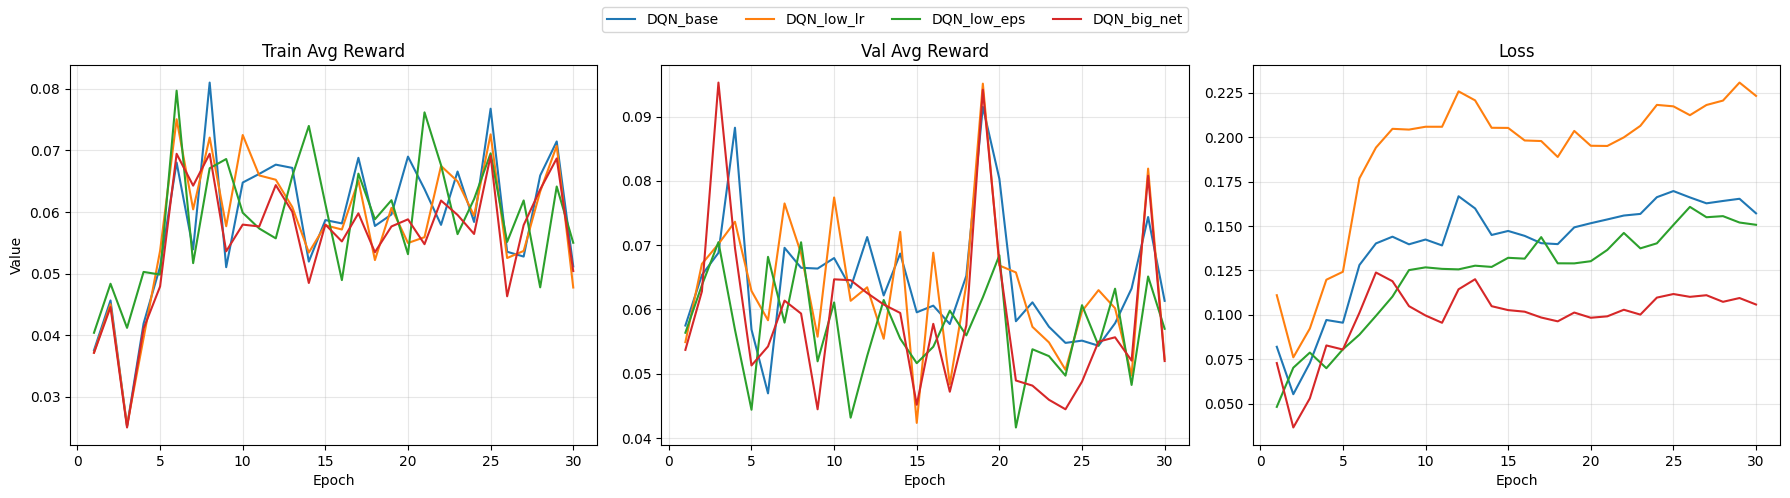

In [67]:
plot_pg_hparam_all_metrics(dqn_hparam_histories)

best config 뽑기

In [68]:
best_row_dqn = df_dqn_hparam.sort_values("val_last", ascending=False).iloc[0]
print("Best DQN config (single seed 기준):")
print(best_row_dqn)

Best DQN config (single seed 기준):
config                 DQN_base
hidden_dim                   64
learning_rate             0.001
epsilon_start               1.0
epsilon_end                0.05
epsilon_decay_steps       50000
batch_size                  256
seed                          0
val_last               0.061344
Name: 0, dtype: object


그 config만 seed 여러 개로 학습하는 함수

In [66]:
def dqn_eval_best_config_multi_seed(
    best_row,
    env_train,
    env_val,
    seeds=(0,1,2),
    n_epochs=30,
    steps_per_epoch=5000,
    eval_episodes=5000,
):
    input_dim      = env_train.X.shape[1]
    hidden_dim     = int(best_row["hidden_dim"])
    learning_rate  = float(best_row["learning_rate"])
    epsilon_start  = float(best_row["epsilon_start"])
    epsilon_end    = float(best_row["epsilon_end"])
    epsilon_decay_steps = int(best_row["epsilon_decay_steps"])
    batch_size     = int(best_row["batch_size"])

    val_scores = []
    best_val = -1e9
    best_model = None
    best_history = None
    best_seed = None

    for seed in seeds:
        print(f"\n==== DQN best config, seed={seed} ====")
        history, final_val, q_net = train_dqn_once(
            env_train=env_train,
            env_val=env_val,
            input_dim=input_dim,
            hidden_dim=hidden_dim,
            learning_rate=learning_rate,
            epsilon_start=epsilon_start,
            epsilon_end=epsilon_end,
            epsilon_decay_steps=epsilon_decay_steps,
            batch_size=batch_size,
            n_epochs=n_epochs,
            steps_per_epoch=steps_per_epoch,
            eval_episodes=eval_episodes,
            seed=seed,
            return_model=True,
        )

        val_scores.append(final_val)

        if final_val > best_val:
            best_val = final_val
            best_model = q_net
            best_history = history
            best_seed = seed

    mean_val = float(np.mean(val_scores))
    std_val  = float(np.std(val_scores))

    print("\n==== DQN best config multi-seed 결과 ====")
    print("seeds:", seeds)
    print(f"val_mean={mean_val:.6f}, val_std={std_val:.6f}")
    print(f"최고 seed={best_seed}, 그때 val={best_val:.6f}")

    return {
        "val_scores": val_scores,
        "val_mean": mean_val,
        "val_std": std_val,
        "best_seed": best_seed,
        "best_val": best_val,
        "best_model": best_model,
        "best_history": best_history,
    }

실행 & DQN 최종본 저장

In [69]:
dqn_best_result = dqn_eval_best_config_multi_seed(
    best_row=best_row_dqn,
    env_train=env_train,
    env_val=env_val,
    seeds=(0,1,2),
    n_epochs=30,
    steps_per_epoch=5000,
    eval_episodes=5000,
)

q_net_dqn_best   = dqn_best_result["best_model"]   # DQN 최종본
dqn_val_mean_best = dqn_best_result["val_mean"]   # 최종 평균 성능
dqn_val_std_best  = dqn_best_result["val_std"]    # 최종 표준편차


==== DQN best config, seed=0 ====
[DQN][Epoch 01] hid=64 lr=0.001 eps0=1.0 train_avg=0.037541 val_avg=0.057506 loss=0.0821
[DQN][Epoch 02] hid=64 lr=0.001 eps0=1.0 train_avg=0.045637 val_avg=0.065368 loss=0.0554
[DQN][Epoch 03] hid=64 lr=0.001 eps0=1.0 train_avg=0.025190 val_avg=0.068809 loss=0.0729
[DQN][Epoch 04] hid=64 lr=0.001 eps0=1.0 train_avg=0.041881 val_avg=0.088271 loss=0.0971
[DQN][Epoch 05] hid=64 lr=0.001 eps0=1.0 train_avg=0.051123 val_avg=0.056885 loss=0.0956
[DQN][Epoch 06] hid=64 lr=0.001 eps0=1.0 train_avg=0.068027 val_avg=0.046950 loss=0.1281
[DQN][Epoch 07] hid=64 lr=0.001 eps0=1.0 train_avg=0.053928 val_avg=0.069592 loss=0.1402
[DQN][Epoch 08] hid=64 lr=0.001 eps0=1.0 train_avg=0.081004 val_avg=0.066487 loss=0.1440
[DQN][Epoch 09] hid=64 lr=0.001 eps0=1.0 train_avg=0.051033 val_avg=0.066366 loss=0.1397
[DQN][Epoch 10] hid=64 lr=0.001 eps0=1.0 train_avg=0.064776 val_avg=0.068001 loss=0.1424
[DQN][Epoch 11] hid=64 lr=0.001 eps0=1.0 train_avg=0.066181 val_avg=0.06337

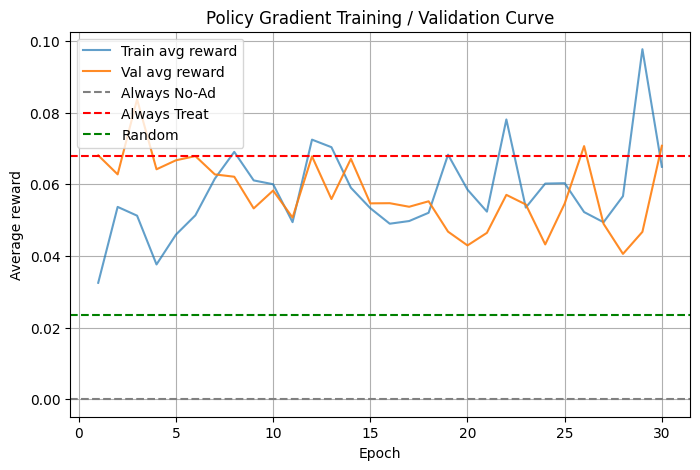

In [70]:
epochs = dqn_best_result['best_history']["epoch"]

plt.figure(figsize=(8,5))
plt.plot(epochs, dqn_best_result['best_history']["train_avg_reward"], label="Train avg reward", alpha=0.7)
plt.plot(epochs, dqn_best_result['best_history']["val_avg_reward"], label="Val avg reward", alpha=0.9)
plt.axhline(avg_no,   color="gray", linestyle="--", label="Always No-Ad")
plt.axhline(avg_all,  color="red",  linestyle="--", label="Always Treat")
plt.axhline(avg_rand, color="green",linestyle="--", label="Random")

plt.xlabel("Epoch")
plt.ylabel("Average reward")
plt.title("Policy Gradient Training / Validation Curve")
plt.legend()
plt.grid(True)
plt.show()


#### 정책별 성능 비교 Bar Plot

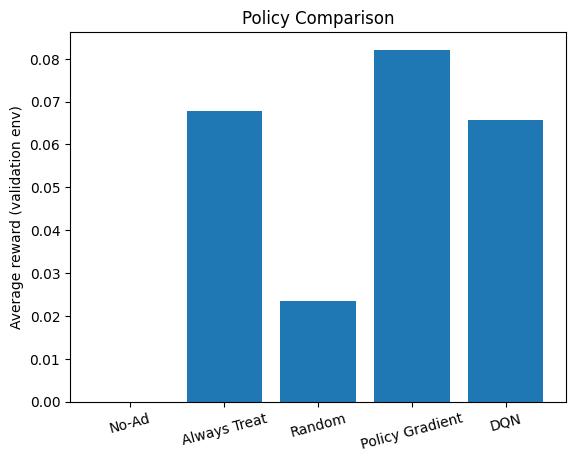

In [71]:
policies = ["No-Ad", "Always Treat", "Random", "Policy Gradient",'DQN']
avg_rewards = [avg_no, avg_all, avg_rand, pg_val_mean_best,dqn_val_mean_best]

plt.bar(policies, avg_rewards)
plt.ylabel("Average reward (validation env)")
plt.title("Policy Comparison")
plt.xticks(rotation=15)
plt.show()

### ③ Actor-critic method

#### Actor-Critic 네트워크 정의

하나의 네트워크에서
- 공유 body →
- policy head (logits, 2차원: action=0,1)
- value head (scalar V(s))
를 동시에 뽑는 구조로 만든다.

In [83]:
import torch.nn.functional as F
class ActorCritic(nn.Module):
    def __init__(self, input_dim, hidden_dim=64, n_actions=2):
        super().__init__()
        self.body = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU()
        )
        self.policy_head = nn.Linear(hidden_dim, n_actions)  # logits
        self.value_head  = nn.Linear(hidden_dim, 1)          # V(s)

    def forward(self, x):
        h = self.body(x)
        logits = self.policy_head(h)        # (batch, n_actions)
        value  = self.value_head(h).squeeze(-1)  # (batch,)
        return logits, value

In [84]:
def train_a2c_once(
    env_train,
    env_val,
    input_dim,
    hidden_dim=64,
    learning_rate=1e-3,
    entropy_coef=0.01,
    value_coef=0.5,
    n_epochs=30,
    steps_per_epoch=2000,
    eval_episodes=5000,
    seed=0,
    return_model=False,
):
    """
    주어진 하이퍼파라미터 + seed로 A2C 한 번 학습.
    history, 마지막 val_avg_reward, (옵션) 모델 반환.
    """
    set_seed(seed)

    ac = ActorCritic(input_dim=input_dim, hidden_dim=hidden_dim, n_actions=2).to(device)
    optimizer = optim.Adam(ac.parameters(), lr=learning_rate)

    history = {
        "epoch": [],
        "train_avg_reward": [],
        "val_avg_reward": [],
        "policy_loss": [],
        "value_loss": [],
        "loss": [],
    }

    for epoch in range(1, n_epochs + 1):
        ac.train()
        log_probs = []
        values = []
        rewards = []
        entropies = []

        # -------- train sampling --------
        for step in range(steps_per_epoch):
            state = env_train.reset()
            state_t = torch.from_numpy(state).float().to(device).unsqueeze(0)

            logits, value = ac(state_t)
            dist = torch.distributions.Categorical(logits=logits)
            action = dist.sample()

            log_prob = dist.log_prob(action)  # (1,)
            entropy = dist.entropy().mean()

            action_int = int(action.item())
            _, r, done, info = env_train.step(action_int)

            log_probs.append(log_prob.squeeze(0))
            values.append(value.squeeze(0))
            rewards.append(r)
            entropies.append(entropy)

        rewards_t   = torch.tensor(rewards, dtype=torch.float32, device=device)  # (N,)
        values_t    = torch.stack(values)                                        # (N,)
        log_probs_t = torch.stack(log_probs)                                     # (N,)
        entropies_t = torch.stack(entropies)                                     # (N,)

        # single-step bandit → return = reward
        returns = rewards_t

        # Advantage = G - V(s)
        advantages = returns - values_t.detach()

        # 안정성을 위해 정규화
        adv_mean = advantages.mean()
        adv_std  = advantages.std() + 1e-8
        advantages = (advantages - adv_mean) / adv_std

        policy_loss = -(log_probs_t * advantages).mean()
        value_loss  = F.mse_loss(values_t, returns)
        entropy_loss = -entropies_t.mean()  # 최소화 기준

        loss = policy_loss + value_coef * value_loss + entropy_coef * entropy_loss

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_avg_reward = rewards_t.mean().item()

        # -------- validation 평가 (greedy policy) --------
        ac.eval()
        def greedy_policy_a2c(state_np):
            s = torch.from_numpy(state_np).float().to(device).unsqueeze(0)
            with torch.no_grad():
                logits, value = ac(s)
                probs = torch.softmax(logits, dim=-1).cpu().numpy()[0]
            return int(np.argmax(probs))

        val_avg_reward, val_std_reward = run_policy(env_val, greedy_policy_a2c, n_episodes=eval_episodes)

        history["epoch"].append(epoch)
        history["train_avg_reward"].append(train_avg_reward)
        history["val_avg_reward"].append(val_avg_reward)
        history["policy_loss"].append(policy_loss.item())
        history["value_loss"].append(value_loss.item())
        history["loss"].append(loss.item())

        print(
            f"[A2C][Epoch {epoch:02d}] "
            f"hid={hidden_dim} lr={learning_rate} ent={entropy_coef} vcoef={value_coef} "
            f"train_avg={train_avg_reward:.6f} val_avg={val_avg_reward:.6f} "
            f"loss={loss.item():.4f}"
        )

    final_val = history["val_avg_reward"][-1]

    if return_model:
        return history, final_val, ac
    else:
        return history, final_val

#### A2C 하이퍼파라미터 비교

비교할 A2C 하이퍼파라미터 후보 예시

기본 설정

learning rate 줄이기

entropy 줄이기 (탐색 줄임)

hidden_dim 키우기

In [85]:
a2c_configs = [
    {"name": "A2C_base",      "hidden_dim": 64,  "learning_rate": 1e-3, "entropy_coef": 0.01, "value_coef": 0.5},
    {"name": "A2C_low_lr",    "hidden_dim": 64,  "learning_rate": 3e-4, "entropy_coef": 0.01, "value_coef": 0.5},
    {"name": "A2C_low_ent",   "hidden_dim": 64,  "learning_rate": 1e-3, "entropy_coef": 0.001,"value_coef": 0.5},
    {"name": "A2C_big_net",   "hidden_dim": 128, "learning_rate": 1e-3, "entropy_coef": 0.01, "value_coef": 0.5},
]

In [86]:
def a2c_hparam_search_single_seed(
    configs,
    env_train,
    env_val,
    seed=0,
    n_epochs=30,
    steps_per_epoch=2000,
    eval_episodes=5000,
):
    """
    seed 하나 고정하고 여러 A2C 하이퍼파라미터 config 비교.
    결과: (DataFrame, histories dict)
    """
    results = []
    input_dim = env_train.X.shape[1]  # 또는 X_train.shape[1]

    a2c_hparam_histories = {}

    for cfg in configs:
        name          = cfg["name"]
        hidden_dim    = cfg["hidden_dim"]
        learning_rate = cfg["learning_rate"]
        entropy_coef  = cfg["entropy_coef"]
        value_coef    = cfg["value_coef"]

        print(f"\n========== A2C Hparam Search: {name} (seed={seed}) ==========")

        history, final_val = train_a2c_once(
            env_train=env_train,
            env_val=env_val,
            input_dim=input_dim,
            hidden_dim=hidden_dim,
            learning_rate=learning_rate,
            entropy_coef=entropy_coef,
            value_coef=value_coef,
            n_epochs=n_epochs,
            steps_per_epoch=steps_per_epoch,
            eval_episodes=eval_episodes,
            seed=seed,
            return_model=False,
        )

        a2c_hparam_histories[name] = history

        results.append({
            "config": name,
            "hidden_dim": hidden_dim,
            "learning_rate": learning_rate,
            "entropy_coef": entropy_coef,
            "value_coef": value_coef,
            "seed": seed,
            "val_last": final_val,
        })

    df = pd.DataFrame(results)
    return df, a2c_hparam_histories


In [87]:
def a2c_hparam_search_single_seed(
    configs,
    env_train,
    env_val,
    seed=0,
    n_epochs=30,
    steps_per_epoch=2000,
    eval_episodes=5000,
):
    """
    seed 하나 고정하고 여러 A2C 하이퍼파라미터 config 비교.
    결과: (DataFrame, histories dict)
    """
    results = []
    input_dim = env_train.X.shape[1]  # 또는 X_train.shape[1]

    a2c_hparam_histories = {}

    for cfg in configs:
        name          = cfg["name"]
        hidden_dim    = cfg["hidden_dim"]
        learning_rate = cfg["learning_rate"]
        entropy_coef  = cfg["entropy_coef"]
        value_coef    = cfg["value_coef"]

        print(f"\n========== A2C Hparam Search: {name} (seed={seed}) ==========")

        history, final_val = train_a2c_once(
            env_train=env_train,
            env_val=env_val,
            input_dim=input_dim,
            hidden_dim=hidden_dim,
            learning_rate=learning_rate,
            entropy_coef=entropy_coef,
            value_coef=value_coef,
            n_epochs=n_epochs,
            steps_per_epoch=steps_per_epoch,
            eval_episodes=eval_episodes,
            seed=seed,
            return_model=False,
        )

        a2c_hparam_histories[name] = history

        results.append({
            "config": name,
            "hidden_dim": hidden_dim,
            "learning_rate": learning_rate,
            "entropy_coef": entropy_coef,
            "value_coef": value_coef,
            "seed": seed,
            "val_last": final_val,
        })

    df = pd.DataFrame(results)
    return df, a2c_hparam_histories


In [88]:
df_a2c_hparam, a2c_hparam_histories = a2c_hparam_search_single_seed(
    configs=a2c_configs,
    env_train=env_train,
    env_val=env_val,
    seed=0,
    n_epochs=30,
    steps_per_epoch=2000,
    eval_episodes=5000,
)

print(df_a2c_hparam)



========== A2C Hparam Search: A2C_base (seed=0) ==========
[A2C][Epoch 01] hid=64 lr=0.001 ent=0.01 vcoef=0.5 train_avg=0.032237 val_avg=0.042717 loss=0.1076
[A2C][Epoch 02] hid=64 lr=0.001 ent=0.01 vcoef=0.5 train_avg=0.044280 val_avg=0.084871 loss=0.2222
[A2C][Epoch 03] hid=64 lr=0.001 ent=0.01 vcoef=0.5 train_avg=0.037915 val_avg=0.076145 loss=0.1112
[A2C][Epoch 04] hid=64 lr=0.001 ent=0.01 vcoef=0.5 train_avg=0.057735 val_avg=0.085554 loss=0.2565
[A2C][Epoch 05] hid=64 lr=0.001 ent=0.01 vcoef=0.5 train_avg=0.069517 val_avg=0.081844 loss=0.3356
[A2C][Epoch 06] hid=64 lr=0.001 ent=0.01 vcoef=0.5 train_avg=0.036645 val_avg=0.055471 loss=0.1301
[A2C][Epoch 07] hid=64 lr=0.001 ent=0.01 vcoef=0.5 train_avg=0.057002 val_avg=0.081133 loss=0.1868
[A2C][Epoch 08] hid=64 lr=0.001 ent=0.01 vcoef=0.5 train_avg=0.037815 val_avg=0.114121 loss=0.0447
[A2C][Epoch 09] hid=64 lr=0.001 ent=0.01 vcoef=0.5 train_avg=0.032868 val_avg=0.070542 loss=0.0371
[A2C][Epoch 10] hid=64 lr=0.001 ent=0.01 vcoef=0.

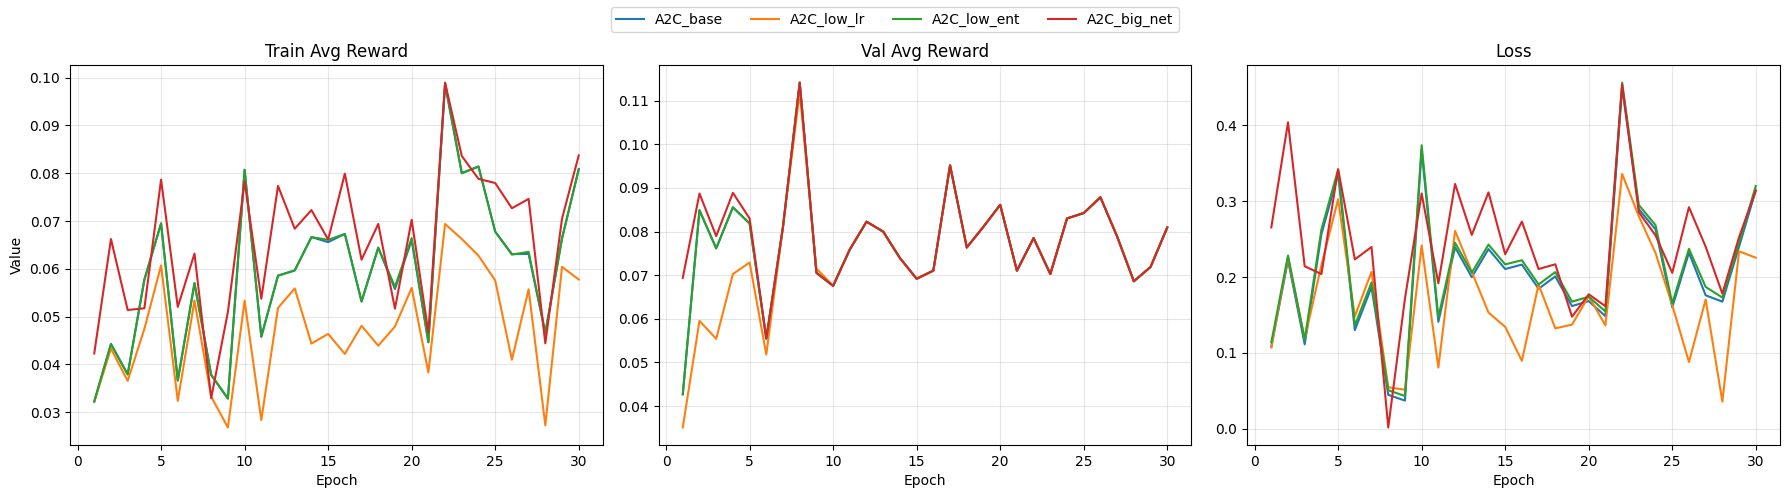

In [92]:
plot_pg_hparam_all_metrics(a2c_hparam_histories)

#### A2C 학습 루프

각 episode가 1-step contextual bandit이므로
- return G = r
- value target = r
- advantage = r - V(s)

#### A2C 정책 평가 & baseline / 다른 알고리즘과 비교

#### 2단계: best config만 seed 여러 개로 학습 → 최종 결과 & 최종 A2C 모델

In [93]:
best_row_a2c = df_a2c_hparam.sort_values("val_last", ascending=False).iloc[0]
print("Best A2C config (single seed 기준):")
print(best_row_a2c)

Best A2C config (single seed 기준):
config           A2C_base
hidden_dim             64
learning_rate       0.001
entropy_coef         0.01
value_coef            0.5
seed                    0
val_last         0.080922
Name: 0, dtype: object


In [94]:
def a2c_eval_best_config_multi_seed(
    best_row,
    env_train,
    env_val,
    seeds=(0,1,2),
    n_epochs=30,
    steps_per_epoch=2000,
    eval_episodes=5000,
):
    input_dim      = env_train.X.shape[1]
    hidden_dim     = int(best_row["hidden_dim"])
    learning_rate  = float(best_row["learning_rate"])
    entropy_coef   = float(best_row["entropy_coef"])
    value_coef     = float(best_row["value_coef"])

    val_scores = []
    best_val = -1e9
    best_model = None
    best_history = None
    best_seed = None

    for seed in seeds:
        print(f"\n==== A2C best config, seed={seed} ====")
        history, final_val, ac = train_a2c_once(
            env_train=env_train,
            env_val=env_val,
            input_dim=input_dim,
            hidden_dim=hidden_dim,
            learning_rate=learning_rate,
            entropy_coef=entropy_coef,
            value_coef=value_coef,
            n_epochs=n_epochs,
            steps_per_epoch=steps_per_epoch,
            eval_episodes=eval_episodes,
            seed=seed,
            return_model=True,
        )

        val_scores.append(final_val)

        if final_val > best_val:
            best_val = final_val
            best_model = ac
            best_history = history
            best_seed = seed

    mean_val = float(np.mean(val_scores))
    std_val  = float(np.std(val_scores))

    print("\n==== A2C best config multi-seed 결과 ====")
    print("seeds:", seeds)
    print(f"val_mean={mean_val:.6f}, val_std={std_val:.6f}")
    print(f"최고 seed={best_seed}, 그때 val={best_val:.6f}")

    return {
        "val_scores": val_scores,
        "val_mean": mean_val,
        "val_std": std_val,
        "best_seed": best_seed,
        "best_val": best_val,
        "best_model": best_model,
        "best_history": best_history,
    }


In [95]:
a2c_best_result = a2c_eval_best_config_multi_seed(
    best_row=best_row_a2c,
    env_train=env_train,
    env_val=env_val,
    seeds=(0,1,2),
    n_epochs=30,
    steps_per_epoch=2000,
    eval_episodes=5000,
)

ac_best          = a2c_best_result["best_model"]   # A2C 최종본
a2c_val_mean_best = a2c_best_result["val_mean"]    # 최종 평균 성능
a2c_val_std_best  = a2c_best_result["val_std"]     # 최종 표준편차



==== A2C best config, seed=0 ====
[A2C][Epoch 01] hid=64 lr=0.001 ent=0.01 vcoef=0.5 train_avg=0.032237 val_avg=0.042717 loss=0.1076
[A2C][Epoch 02] hid=64 lr=0.001 ent=0.01 vcoef=0.5 train_avg=0.044280 val_avg=0.084871 loss=0.2222
[A2C][Epoch 03] hid=64 lr=0.001 ent=0.01 vcoef=0.5 train_avg=0.037915 val_avg=0.076145 loss=0.1112
[A2C][Epoch 04] hid=64 lr=0.001 ent=0.01 vcoef=0.5 train_avg=0.057735 val_avg=0.085554 loss=0.2565
[A2C][Epoch 05] hid=64 lr=0.001 ent=0.01 vcoef=0.5 train_avg=0.069517 val_avg=0.081844 loss=0.3356
[A2C][Epoch 06] hid=64 lr=0.001 ent=0.01 vcoef=0.5 train_avg=0.036645 val_avg=0.055471 loss=0.1301
[A2C][Epoch 07] hid=64 lr=0.001 ent=0.01 vcoef=0.5 train_avg=0.057002 val_avg=0.081133 loss=0.1868
[A2C][Epoch 08] hid=64 lr=0.001 ent=0.01 vcoef=0.5 train_avg=0.037815 val_avg=0.114121 loss=0.0447
[A2C][Epoch 09] hid=64 lr=0.001 ent=0.01 vcoef=0.5 train_avg=0.032868 val_avg=0.070542 loss=0.0371
[A2C][Epoch 10] hid=64 lr=0.001 ent=0.01 vcoef=0.5 train_avg=0.080725 val_

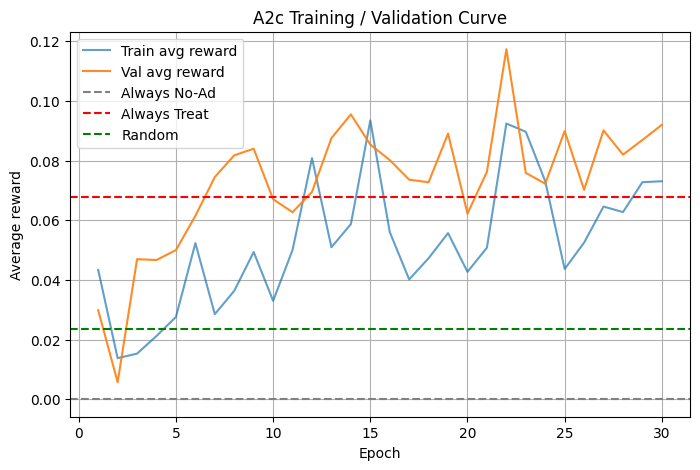

In [96]:
epochs = a2c_best_result['best_history']["epoch"]

plt.figure(figsize=(8,5))
plt.plot(epochs, a2c_best_result['best_history']["train_avg_reward"], label="Train avg reward", alpha=0.7)
plt.plot(epochs, a2c_best_result['best_history']["val_avg_reward"], label="Val avg reward", alpha=0.9)
plt.axhline(avg_no,   color="gray", linestyle="--", label="Always No-Ad")
plt.axhline(avg_all,  color="red",  linestyle="--", label="Always Treat")
plt.axhline(avg_rand, color="green",linestyle="--", label="Random")

plt.xlabel("Epoch")
plt.ylabel("Average reward")
plt.title("A2c Training / Validation Curve")
plt.legend()
plt.grid(True)
plt.show()


#### 정책별 성능 비교 Bar Plot

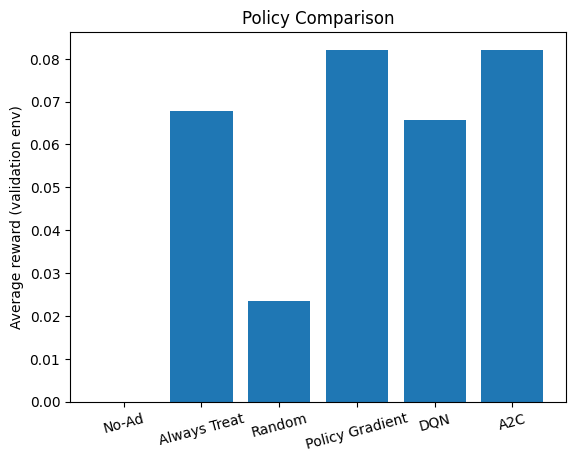

In [97]:
policies = ["No-Ad", "Always Treat", "Random", "Policy Gradient",'DQN','A2C']
avg_rewards = [avg_no, avg_all, avg_rand, pg_val_mean_best,dqn_val_mean_best,a2c_val_mean_best]

plt.bar(policies, avg_rewards)
plt.ylabel("Average reward (validation env)")
plt.title("Policy Comparison")
plt.xticks(rotation=15)
plt.show()

### 전체 알고리즘 비교 (Baseline + PG + DQN + A2C)

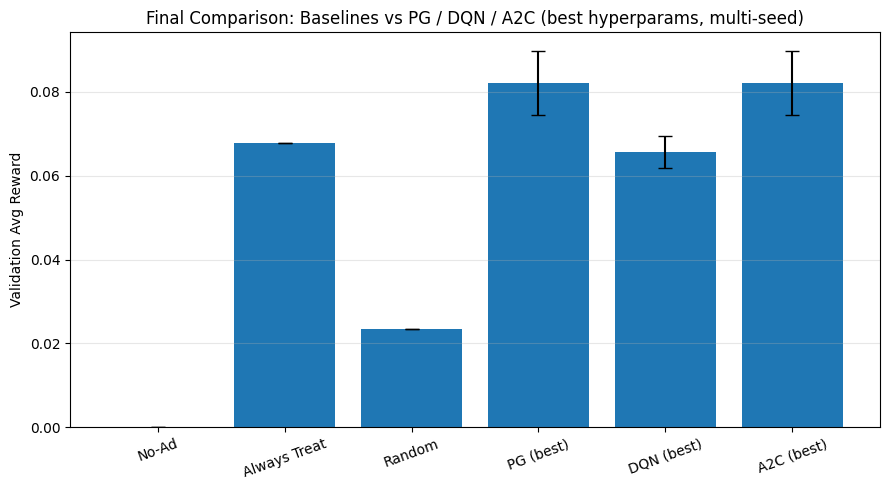

In [98]:
policies = ["No-Ad", "Always Treat", "Random", "PG (best)", "DQN (best)", "A2C (best)"]
means = [
    avg_no,
    avg_all,
    avg_rand,
    pg_val_mean_best,
    dqn_val_mean_best,
    a2c_val_mean_best,
]
stds = [
    0.0,
    0.0,
    0.0,
    pg_val_std_best,
    dqn_val_std_best,
    a2c_val_std_best,
]

x = np.arange(len(policies))

plt.figure(figsize=(9,5))
plt.bar(x, means, yerr=stds, capsize=5)
plt.xticks(x, policies, rotation=20)
plt.ylabel("Validation Avg Reward")
plt.title("Final Comparison: Baselines vs PG / DQN / A2C (best hyperparams, multi-seed)")
plt.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.show()


In [102]:
print(pg_val_mean_best)
print(a2c_val_mean_best)

0.08214266658357033
0.08214266658357033


In [103]:
def greedy_policy_pg(state_np):
    s = torch.from_numpy(state_np).float().to(device).unsqueeze(0)
    with torch.no_grad():
        logits = policy_pg_best(s)
        probs = torch.softmax(logits, dim=-1).cpu().numpy()[0]
    return int(np.argmax(probs))

def greedy_policy_a2c(state_np):
    s = torch.from_numpy(state_np).float().to(device).unsqueeze(0)
    with torch.no_grad():
        logits, value = ac_best(s)
        probs = torch.softmax(logits, dim=-1).cpu().numpy()[0]
    return int(np.argmax(probs))


In [104]:
def compare_policies(env, policy_fn1, policy_fn2, n_samples=5000):
    diff = 0
    for _ in range(n_samples):
        s = env.reset()
        a1 = policy_fn1(s)
        a2 = policy_fn2(s)
        if a1 != a2:
            diff += 1
    print(f"서로 다른 action 비율: {diff / n_samples:.4f}")

compare_policies(env_val, greedy_policy_pg, greedy_policy_a2c, n_samples=10000)


서로 다른 action 비율: 0.0000


In [107]:
print(pg_best_result['val_scores'])
print(a2c_best_result['val_scores'])

[np.float64(0.08092200004253536), np.float64(0.07350400007255375), np.float64(0.0920019996356219)]
[np.float64(0.08092200004253536), np.float64(0.07350400007255375), np.float64(0.0920019996356219)]


#### 알고리즘별 정책 확인

In [108]:
def get_pg_policy_for_states(policy_pg_best, X, batch_size=2048):
    """
    X: numpy array, shape = (N, input_dim)
    반환: dict
      - "pg_prob_treat": π(a=1 | s)
      - "pg_action": greedy action (0 or 1)
    """
    policy_pg_best.eval()
    N = X.shape[0]

    probs_list = []
    acts_list = []

    with torch.no_grad():
        for i in range(0, N, batch_size):
            x_batch = X[i:i+batch_size]
            x_t = torch.from_numpy(x_batch).float().to(device)
            logits = policy_pg_best(x_t)               # (B, 2)
            probs = torch.softmax(logits, dim=-1)      # (B, 2)
            prob_treat = probs[:, 1].cpu().numpy()     # (B,)
            action = probs.argmax(dim=-1).cpu().numpy()# (B,)
            probs_list.append(prob_treat)
            acts_list.append(action)

    pg_prob_treat = np.concatenate(probs_list)
    pg_action = np.concatenate(acts_list)
    return {
        "pg_prob_treat": pg_prob_treat,
        "pg_action": pg_action,
    }

def get_a2c_policy_for_states(ac_best, X, batch_size=2048):
    """
    X: numpy array, shape = (N, input_dim)
    반환: dict
      - "a2c_prob_treat": π(a=1 | s)
      - "a2c_action": greedy action (0 or 1)
    """
    ac_best.eval()
    N = X.shape[0]

    probs_list = []
    acts_list = []

    with torch.no_grad():
        for i in range(0, N, batch_size):
            x_batch = X[i:i+batch_size]
            x_t = torch.from_numpy(x_batch).float().to(device)
            logits, values = ac_best(x_t)              # logits: (B,2)
            probs = torch.softmax(logits, dim=-1)
            prob_treat = probs[:, 1].cpu().numpy()
            action = probs.argmax(dim=-1).cpu().numpy()
            probs_list.append(prob_treat)
            acts_list.append(action)

    a2c_prob_treat = np.concatenate(probs_list)
    a2c_action = np.concatenate(acts_list)
    return {
        "a2c_prob_treat": a2c_prob_treat,
        "a2c_action": a2c_action,
    }

def get_dqn_policy_for_states(q_net_dqn_best, X, batch_size=2048):
    """
    X: numpy array, shape = (N, input_dim)
    반환: dict
      - "dqn_q0": Q(s,0)
      - "dqn_q1": Q(s,1)
      - "dqn_action": greedy action (0 or 1)
      - "dqn_pref_treat": Q(s,1) - Q(s,0)  (양수면 treat 선호)
    """
    q_net_dqn_best.eval()
    N = X.shape[0]

    q0_list = []
    q1_list = []
    acts_list = []
    pref_list = []

    with torch.no_grad():
        for i in range(0, N, batch_size):
            x_batch = X[i:i+batch_size]
            x_t = torch.from_numpy(x_batch).float().to(device)
            q_values = q_net_dqn_best(x_t)             # (B, 2)
            q_np = q_values.cpu().numpy()
            q0 = q_np[:, 0]
            q1 = q_np[:, 1]
            action = q_np.argmax(axis=1)
            pref = q1 - q0

            q0_list.append(q0)
            q1_list.append(q1)
            acts_list.append(action)
            pref_list.append(pref)

    dqn_q0 = np.concatenate(q0_list)
    dqn_q1 = np.concatenate(q1_list)
    dqn_action = np.concatenate(acts_list)
    dqn_pref = np.concatenate(pref_list)

    return {
        "dqn_q0": dqn_q0,
        "dqn_q1": dqn_q1,
        "dqn_action": dqn_action,
        "dqn_pref_treat": dqn_pref,
    }


In [119]:
# 분석할 샘플 개수 (너무 크면 느리니까 일부만)
n_samples = 10000
idx = np.random.choice(len(X_val), size=min(n_samples, len(X_val)), replace=False)

X_sample  = X_val[idx]
df_sample = pd.DataFrame(X_val,columns=feature_cols).iloc[idx].copy()  # 원본 feature/label도 같이 보고 싶을 때

# 각 모델별 policy 계산
pg_info  = get_pg_policy_for_states(policy_pg_best, X_sample)
a2c_info = get_a2c_policy_for_states(ac_best, X_sample)
dqn_info = get_dqn_policy_for_states(q_net_dqn_best, X_sample)

# DataFrame에 붙이기
df_policy_view = df_sample.copy()
df_policy_view["pg_prob_treat"]   = pg_info["pg_prob_treat"]
df_policy_view["pg_action"]       = pg_info["pg_action"]

df_policy_view["a2c_prob_treat"]  = a2c_info["a2c_prob_treat"]
df_policy_view["a2c_action"]      = a2c_info["a2c_action"]

df_policy_view["dqn_q0"]          = dqn_info["dqn_q0"]
df_policy_view["dqn_q1"]          = dqn_info["dqn_q1"]
df_policy_view["dqn_pref_treat"]  = dqn_info["dqn_pref_treat"]
df_policy_view["dqn_action"]      = dqn_info["dqn_action"]

df_policy_view.head()


,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,pg_prob_treat,pg_action,a2c_prob_treat,a2c_action,dqn_q0,dqn_q1,dqn_pref_treat,dqn_action
15892,0.421053,-0.099809,-0.770129,0.375620,-0.168927,0.203247,-2.150048,-0.224165,0.670654,-0.401836,-0.196677,0.100662,0.532728,1,0.712823,1,0.000311,-0.019827,-0.020138,0
17614,-1.310642,-0.099809,1.366866,0.375620,-0.168927,0.203247,0.974904,-0.224165,-0.664963,-0.401836,-0.196677,0.100662,0.673163,1,0.631917,1,0.000480,-0.039330,-0.039809,0
11825,-0.483498,-0.099809,0.841501,-1.593585,-0.168927,0.203247,-0.203482,-0.224165,-0.113256,-0.401836,-0.196677,0.100662,0.575089,1,0.638724,1,0.000277,-0.011479,-0.011755,0
2758,-1.310642,-0.099809,-0.099969,0.375620,-0.168927,0.203247,0.974904,-0.224165,-1.186484,1.581777,-0.196677,0.100662,0.826739,1,0.721352,1,0.006809,-0.147012,-0.153821,0
3226,-0.234289,-0.099809,0.512549,-3.212129,-0.168927,0.203247,-1.172031,-0.224165,-0.223248,0.925760,-0.196677,0.100662,0.619472,1,0.757761,1,0.000457,0.207802,0.207345,1


In [121]:
# 세 모델이 의견이 다른 케이스만 뽑아보는 것도 가능
df_diff = df_policy_view[
    (df_policy_view["pg_action"] != df_policy_view["a2c_action"])
]

df_diff.head()


,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,pg_prob_treat,pg_action,a2c_prob_treat,a2c_action,dqn_q0,dqn_q1,dqn_pref_treat,dqn_action


In [126]:
  # f0~f11을 구간으로 나눠서 bucket 만들기
  feature_cols_for_bins = [f"f{i}" for i in range(12)]

  for col in feature_cols_for_bins:
      try:
          df_policy_view[f"{col}_bin"] = pd.qcut(df_policy_view[col], q=5, duplicates="drop")
      except ValueError as e:
          print(f"Warning: Could not create bins for column {col} - {e}")

In [132]:
for col in feature_cols_for_bins:
    bin_col_name = f"{col}_bin"
    if bin_col_name in df_policy_view.columns:
        print(f"\n--- Groupby results for {bin_col_name} ---")
        display(df_policy_view.groupby(bin_col_name, observed=False)[["pg_action", "a2c_action", "dqn_action"]].mean())
    else:
        print(f"Warning: {bin_col_name} not found in df_policy_view. Skipping.")


--- Groupby results for f0_bin ---


,pg_action,a2c_action,dqn_action
f0_bin,,,
"(-1.3119999999999998, -0.368]",1.0,1.0,0.26875
"(-0.368, 0.582]",1.0,1.0,0.21750
"(0.582, 0.962]",1.0,1.0,0.14250
"(0.962, 1.323]",1.0,1.0,0.08800



--- Groupby results for f1_bin ---


,pg_action,a2c_action,dqn_action
f1_bin,,,
"(-0.1008, 26.692]",1.0,1.0,0.1971



--- Groupby results for f2_bin ---


,pg_action,a2c_action,dqn_action
f2_bin,,,
"(-0.771, -0.165]",1.0,1.0,0.156333
"(-0.165, 1.228]",1.0,1.0,0.371000
"(1.228, 2.031]",1.0,1.0,0.145500



--- Groupby results for f3_bin ---


,pg_action,a2c_action,dqn_action
f3_bin,,,
"(-6.916, 0.376]",1.0,1.0,0.1971



--- Groupby results for f4_bin ---


,pg_action,a2c_action,dqn_action
f4_bin,,,
"(-0.17, 21.882]",1.0,1.0,0.1971



--- Groupby results for f5_bin ---


,pg_action,a2c_action,dqn_action
f5_bin,,,
"(-16.654, 0.203]",1.0,1.0,0.1971



--- Groupby results for f6_bin ---


,pg_action,a2c_action,dqn_action
f6_bin,,,
"(-4.056, -0.844]",1.0,1.0,0.430624
"(-0.844, 0.0411]",1.0,1.0,0.188817
"(0.0411, 0.63]",1.0,1.0,0.071549
"(0.63, 0.975]",1.0,1.0,0.167910



--- Groupby results for f7_bin ---


,pg_action,a2c_action,dqn_action
f7_bin,,,
"(-0.225, 5.655]",1.0,1.0,0.1971



--- Groupby results for f8_bin ---


,pg_action,a2c_action,dqn_action
f8_bin,,,
"(-4.714, -0.718]",1.0,1.0,0.446100
"(-0.718, 0.176]",1.0,1.0,0.260113
"(0.176, 0.671]",1.0,1.0,0.088722



--- Groupby results for f9_bin ---


,pg_action,a2c_action,dqn_action
f9_bin,,,
"(-0.403, 0.0278]",1.0,1.0,0.130922
"(0.0278, 6.259]",1.0,1.0,0.500838



--- Groupby results for f10_bin ---


,pg_action,a2c_action,dqn_action
f10_bin,,,
"(-0.198, 6.774]",1.0,1.0,0.1971



--- Groupby results for f11_bin ---


,pg_action,a2c_action,dqn_action
f11_bin,,,
"(-23.212, 0.101]",1.0,1.0,0.1971


In [137]:
base = (
    conv_reward * df["conversion"]
    + visit_reward * df["visit"] * (df["conversion"] == 0)
    -treat_cost
)
print((base > 0).mean())


0.04685046850468505


In [135]:

print((base > 0).mean())   # base 자체가 몇 %나 양수인지
print(base.describe())


0.04685046850468505
count    99999.000000
mean         0.088431
std          0.839240
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max         15.000000
dtype: float64


In [138]:
baseline = base.mean()  # == df['reward_if_treat'].mean() 과 거의 동일한 값일 것

df["reward_if_treat_centered"] = base - baseline

print(df["reward_if_treat_centered"].mean())        # ≈ 0 근처
print((df["reward_if_treat_centered"] > 0).mean())  # 여전히 ~0.04~0.05 수준


1.449521676167366e-17
0.04685046850468505


### Reward centered

In [145]:
# feature: f0 ~ f11
feature_cols = [f"f{i}" for i in range(12)]

X2 = df[feature_cols].values.astype(np.float32)
y_r2 = df['reward_if_treat_centered'].values.astype(np.float32)

# train / validation 분할
X_train_bf2, X_val_bf2, r2_train, r2_val = train_test_split(
    X, y_r2, test_size=0.2, random_state=42
)

In [146]:
# 표준화
scaler = StandardScaler()
X_train2 = scaler.fit_transform(X_train_bf2)
X_val2   = scaler.transform(X_val_bf2)

print("Train data :", X_train2.shape)
print("Validation data :", X_val2.shape)

Train data : (79999, 12)
Validation data : (20000, 12)


In [147]:
# 환경 생성 (train / val)
env_train2 = AdEnvironment(X_train2, r2_train)
env_val2   = AdEnvironment(X_val2,   r2_val)

In [155]:
# 평가
avg_no2, std_no2 = run_policy(env_val2, policy_always_no_ad)
avg_all2, std_all2 = run_policy(env_val2, policy_always_treat)
avg_rand2, std_rand2 = run_policy(env_val2, policy_random)

print(f"Always No-Ad:  avg_reward={avg_no2:.4f} ± {std_no:.4f}")
print(f"Always Treat:  avg_reward={avg_all2:.4f} ± {std_all:.4f}")
print(f"Random Policy: avg_reward={avg_rand2:.4f} ± {std_rand:.4f}")

Always No-Ad:  avg_reward=0.0000 ± 0.0000
Always Treat:  avg_reward=0.0068 ± 0.7604
Random Policy: avg_reward=0.0084 ± 0.3933


### ① Policy gradient

In [156]:
pg_best_result2 = pg_eval_best_config_multi_seed(
    best_row=best_row,
    env_train=env_train2,
    env_val=env_val2,
    seeds=(0,1,2),  # or (0,1,2,3,4)
    n_epochs=30,
    steps_per_epoch=2000,
    eval_episodes=5000,
)

policy_pg_best2   = pg_best_result2["best_model"]    # PG 최종본 모델
pg_val_mean_best2 = pg_best_result2["val_mean"]      # 보고서용 평균 성능
pg_val_std_best2  = pg_best_result2["val_std"]       # 보고서용 표준편차


==== PG best config, seed=0 ====
[PG][Epoch 01] hid=64 lr=0.001 ent=0.0 train_avg=0.001275 val_avg=-0.044594
[PG][Epoch 02] hid=64 lr=0.001 ent=0.0 train_avg=0.015710 val_avg=-0.033911
[PG][Epoch 03] hid=64 lr=0.001 ent=0.0 train_avg=-0.012593 val_avg=-0.019932
[PG][Epoch 04] hid=64 lr=0.001 ent=0.0 train_avg=0.008890 val_avg=-0.011680
[PG][Epoch 05] hid=64 lr=0.001 ent=0.0 train_avg=0.012390 val_avg=-0.019053
[PG][Epoch 06] hid=64 lr=0.001 ent=0.0 train_avg=0.001761 val_avg=-0.031647
[PG][Epoch 07] hid=64 lr=0.001 ent=0.0 train_avg=-0.007344 val_avg=0.000534
[PG][Epoch 08] hid=64 lr=0.001 ent=0.0 train_avg=-0.008538 val_avg=0.036493
[PG][Epoch 09] hid=64 lr=0.001 ent=0.0 train_avg=0.001608 val_avg=-0.000589
[PG][Epoch 10] hid=64 lr=0.001 ent=0.0 train_avg=0.025244 val_avg=-0.002616
[PG][Epoch 11] hid=64 lr=0.001 ent=0.0 train_avg=-0.002623 val_avg=0.009318
[PG][Epoch 12] hid=64 lr=0.001 ent=0.0 train_avg=0.000710 val_avg=0.016774
[PG][Epoch 13] hid=64 lr=0.001 ent=0.0 train_avg=0.017

② DQN

In [157]:
dqn_best_result2 = dqn_eval_best_config_multi_seed(
    best_row=best_row_dqn,
    env_train=env_train2,
    env_val=env_val2,
    seeds=(0,1,2),
    n_epochs=30,
    steps_per_epoch=5000,
    eval_episodes=5000,
)

q_net_dqn_best2   = dqn_best_result2["best_model"]   # DQN 최종본
dqn_val_mean_best2 = dqn_best_result2["val_mean"]   # 최종 평균 성능
dqn_val_std_best2  = dqn_best_result2["val_std"]    # 최종 표준편차


==== DQN best config, seed=0 ====
[DQN][Epoch 01] hid=64 lr=0.001 eps0=1.0 train_avg=-0.000426 val_avg=0.033997 loss=0.0797
[DQN][Epoch 02] hid=64 lr=0.001 eps0=1.0 train_avg=0.009916 val_avg=0.055745 loss=0.0536
[DQN][Epoch 03] hid=64 lr=0.001 eps0=1.0 train_avg=-0.006991 val_avg=0.061838 loss=0.0674
[DQN][Epoch 04] hid=64 lr=0.001 eps0=1.0 train_avg=0.016225 val_avg=0.052696 loss=0.1041
[DQN][Epoch 05] hid=64 lr=0.001 eps0=1.0 train_avg=0.027023 val_avg=0.042605 loss=0.1078
[DQN][Epoch 06] hid=64 lr=0.001 eps0=1.0 train_avg=0.043361 val_avg=0.031672 loss=0.1299
[DQN][Epoch 07] hid=64 lr=0.001 eps0=1.0 train_avg=0.034121 val_avg=0.047256 loss=0.1417
[DQN][Epoch 08] hid=64 lr=0.001 eps0=1.0 train_avg=0.040892 val_avg=0.038906 loss=0.1420
[DQN][Epoch 09] hid=64 lr=0.001 eps0=1.0 train_avg=0.031250 val_avg=0.053534 loss=0.1332
[DQN][Epoch 10] hid=64 lr=0.001 eps0=1.0 train_avg=0.044258 val_avg=0.067933 loss=0.1332
[DQN][Epoch 11] hid=64 lr=0.001 eps0=1.0 train_avg=0.047533 val_avg=0.044

③ A2C

In [158]:
a2c_best_result2 = a2c_eval_best_config_multi_seed(
    best_row=best_row_a2c,
    env_train=env_train2,
    env_val=env_val2,
    seeds=(0,1,2),
    n_epochs=30,
    steps_per_epoch=2000,
    eval_episodes=5000,
)

ac_best2          = a2c_best_result2["best_model"]   # A2C 최종본
a2c_val_mean_best2 = a2c_best_result2["val_mean"]    # 최종 평균 성능
a2c_val_std_best2  = a2c_best_result2["val_std"]     # 최종 표준편차



==== A2C best config, seed=0 ====
[A2C][Epoch 01] hid=64 lr=0.001 ent=0.01 vcoef=0.5 train_avg=-0.005760 val_avg=-0.006769 loss=0.1132
[A2C][Epoch 02] hid=64 lr=0.001 ent=0.01 vcoef=0.5 train_avg=0.004104 val_avg=0.031281 loss=0.2262
[A2C][Epoch 03] hid=64 lr=0.001 ent=0.01 vcoef=0.5 train_avg=-0.001086 val_avg=0.025310 loss=0.1165
[A2C][Epoch 04] hid=64 lr=0.001 ent=0.01 vcoef=0.5 train_avg=0.017281 val_avg=0.029746 loss=0.2619
[A2C][Epoch 05] hid=64 lr=0.001 ent=0.01 vcoef=0.5 train_avg=0.028689 val_avg=0.026165 loss=0.3411
[A2C][Epoch 06] hid=64 lr=0.001 ent=0.01 vcoef=0.5 train_avg=-0.004205 val_avg=0.005146 loss=0.1369
[A2C][Epoch 07] hid=64 lr=0.001 ent=0.01 vcoef=0.5 train_avg=0.015203 val_avg=0.026078 loss=0.1921
[A2C][Epoch 08] hid=64 lr=0.001 ent=0.01 vcoef=0.5 train_avg=-0.002807 val_avg=0.068814 loss=0.0513
[A2C][Epoch 09] hid=64 lr=0.001 ent=0.01 vcoef=0.5 train_avg=-0.009355 val_avg=0.024225 loss=0.0423
[A2C][Epoch 10] hid=64 lr=0.001 ent=0.01 vcoef=0.5 train_avg=0.03944

In [159]:
# 분석할 샘플 개수 (너무 크면 느리니까 일부만)
n_samples = 10000
idx = np.random.choice(len(X_val2), size=min(n_samples, len(X_val2)), replace=False)

X_sample2  = X_val2[idx]
df_sample2 = pd.DataFrame(X_val_bf2,columns=feature_cols).iloc[idx].copy()  # 원본 feature/label도 같이 보고 싶을 때

# 각 모델별 policy 계산
pg_info  = get_pg_policy_for_states(policy_pg_best2, X_sample2)
a2c_info = get_a2c_policy_for_states(ac_best2, X_sample2)
dqn_info = get_dqn_policy_for_states(q_net_dqn_best2, X_sample2)

# DataFrame에 붙이기
df_policy_view = df_sample.copy()
df_policy_view["pg_prob_treat"]   = pg_info["pg_prob_treat"]
df_policy_view["pg_action"]       = pg_info["pg_action"]

df_policy_view["a2c_prob_treat"]  = a2c_info["a2c_prob_treat"]
df_policy_view["a2c_action"]      = a2c_info["a2c_action"]

df_policy_view["dqn_q0"]          = dqn_info["dqn_q0"]
df_policy_view["dqn_q1"]          = dqn_info["dqn_q1"]
df_policy_view["dqn_pref_treat"]  = dqn_info["dqn_pref_treat"]
df_policy_view["dqn_action"]      = dqn_info["dqn_action"]

df_policy_view.head()


,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,pg_prob_treat,pg_action,a2c_prob_treat,a2c_action,dqn_q0,dqn_q1,dqn_pref_treat,dqn_action
15892,0.421053,-0.099809,-0.770129,0.375620,-0.168927,0.203247,-2.150048,-0.224165,0.670654,-0.401836,-0.196677,0.100662,0.710767,1,0.696994,1,-0.000021,-0.218860,-0.218839,0
17614,-1.310642,-0.099809,1.366866,0.375620,-0.168927,0.203247,0.974904,-0.224165,-0.664963,-0.401836,-0.196677,0.100662,0.751534,1,0.576540,1,-0.001689,-0.039168,-0.037480,0
11825,-0.483498,-0.099809,0.841501,-1.593585,-0.168927,0.203247,-0.203482,-0.224165,-0.113256,-0.401836,-0.196677,0.100662,0.809504,1,0.820112,1,-0.000396,-0.512215,-0.511819,0
2758,-1.310642,-0.099809,-0.099969,0.375620,-0.168927,0.203247,0.974904,-0.224165,-1.186484,1.581777,-0.196677,0.100662,0.566950,1,0.499198,0,-0.000034,-0.184395,-0.184361,0
3226,-0.234289,-0.099809,0.512549,-3.212129,-0.168927,0.203247,-1.172031,-0.224165,-0.223248,0.925760,-0.196677,0.100662,0.307741,0,0.461727,0,-0.000032,-0.064715,-0.064683,0


In [160]:
# 세 모델이 의견이 다른 케이스만 뽑아보는 것도 가능
df_diff = df_policy_view[
    (df_policy_view["pg_action"] != df_policy_view["a2c_action"])
]

df_diff.head()


,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,pg_prob_treat,pg_action,a2c_prob_treat,a2c_action,dqn_q0,dqn_q1,dqn_pref_treat,dqn_action
2758,-1.310642,-0.099809,-0.099969,0.37562,-0.168927,0.203247,0.974904,-0.224165,-1.186484,1.581777,-0.196677,0.100662,0.566950,1,0.499198,0,-0.000034,-0.184395,-0.184361,0
18526,-1.310642,-0.099809,-0.058260,0.37562,3.492599,0.203247,0.974904,-0.224165,-1.391756,2.661190,1.581870,-6.916815,0.404615,0,0.632597,1,0.000086,-0.373034,-0.373120,0
10008,-1.310642,-0.099809,-0.673885,0.37562,-0.168927,0.203247,0.974904,-0.224165,-0.935744,1.983935,-0.196677,0.100662,0.539841,1,0.455572,0,-0.000176,0.001240,0.001416,1
699,0.900186,-0.099809,-0.770129,0.37562,-0.168927,0.203247,-1.327009,-0.224165,0.670654,-0.401836,-0.196677,0.100662,0.454598,0,0.579358,1,0.000039,0.076143,0.076104,1
12986,-1.310642,-0.099809,-0.160948,0.37562,-0.168927,0.203247,0.974904,-0.224165,-0.767069,0.332716,-0.196677,0.100662,0.407507,0,0.590625,1,0.000048,-0.184406,-0.184455,0


In [161]:
  # f0~f11을 구간으로 나눠서 bucket 만들기
  feature_cols_for_bins = [f"f{i}" for i in range(12)]

  for col in feature_cols_for_bins:
      try:
          df_policy_view[f"{col}_bin"] = pd.qcut(df_policy_view[col], q=5, duplicates="drop")
      except ValueError as e:
          print(f"Warning: Could not create bins for column {col} - {e}")

In [162]:
for col in feature_cols_for_bins:
    bin_col_name = f"{col}_bin"
    if bin_col_name in df_policy_view.columns:
        print(f"\n--- Groupby results for {bin_col_name} ---")
        display(df_policy_view.groupby(bin_col_name, observed=False)[["pg_action", "a2c_action", "dqn_action"]].mean())
    else:
        print(f"Warning: {bin_col_name} not found in df_policy_view. Skipping.")


--- Groupby results for f0_bin ---


,pg_action,a2c_action,dqn_action
f0_bin,,,
"(-1.3119999999999998, -0.368]",0.2890,0.29275,0.13375
"(-0.368, 0.582]",0.3085,0.31600,0.13950
"(0.582, 0.962]",0.3125,0.31050,0.13600
"(0.962, 1.323]",0.3015,0.30950,0.14100



--- Groupby results for f1_bin ---


,pg_action,a2c_action,dqn_action
f1_bin,,,
"(-0.1008, 26.692]",0.3001,0.3043,0.1368



--- Groupby results for f2_bin ---


,pg_action,a2c_action,dqn_action
f2_bin,,,
"(-0.771, -0.165]",0.306667,0.311167,0.140
"(-0.165, 1.228]",0.290500,0.298000,0.130
"(1.228, 2.031]",0.290000,0.290000,0.134



--- Groupby results for f3_bin ---


,pg_action,a2c_action,dqn_action
f3_bin,,,
"(-6.916, 0.376]",0.3001,0.3043,0.1368



--- Groupby results for f4_bin ---


,pg_action,a2c_action,dqn_action
f4_bin,,,
"(-0.17, 21.882]",0.3001,0.3043,0.1368



--- Groupby results for f5_bin ---


,pg_action,a2c_action,dqn_action
f5_bin,,,
"(-16.654, 0.203]",0.3001,0.3043,0.1368



--- Groupby results for f6_bin ---


,pg_action,a2c_action,dqn_action
f6_bin,,,
"(-4.056, -0.844]",0.287909,0.291378,0.130823
"(-0.844, 0.0411]",0.302796,0.313548,0.140215
"(0.0411, 0.63]",0.306013,0.314410,0.139066
"(0.63, 0.975]",0.300373,0.294776,0.135821



--- Groupby results for f7_bin ---


,pg_action,a2c_action,dqn_action
f7_bin,,,
"(-0.225, 5.655]",0.3001,0.3043,0.1368



--- Groupby results for f8_bin ---


,pg_action,a2c_action,dqn_action
f8_bin,,,
"(-4.714, -0.718]",0.297069,0.300050,0.135618
"(-0.718, 0.176]",0.289276,0.289276,0.129351
"(0.176, 0.671]",0.305067,0.311210,0.139908



--- Groupby results for f9_bin ---


,pg_action,a2c_action,dqn_action
f9_bin,,,
"(-0.403, 0.0278]",0.300938,0.306905,0.139082
"(0.0278, 6.259]",0.296255,0.292342,0.126328



--- Groupby results for f10_bin ---


,pg_action,a2c_action,dqn_action
f10_bin,,,
"(-0.198, 6.774]",0.3001,0.3043,0.1368



--- Groupby results for f11_bin ---


,pg_action,a2c_action,dqn_action
f11_bin,,,
"(-23.212, 0.101]",0.3001,0.3043,0.1368


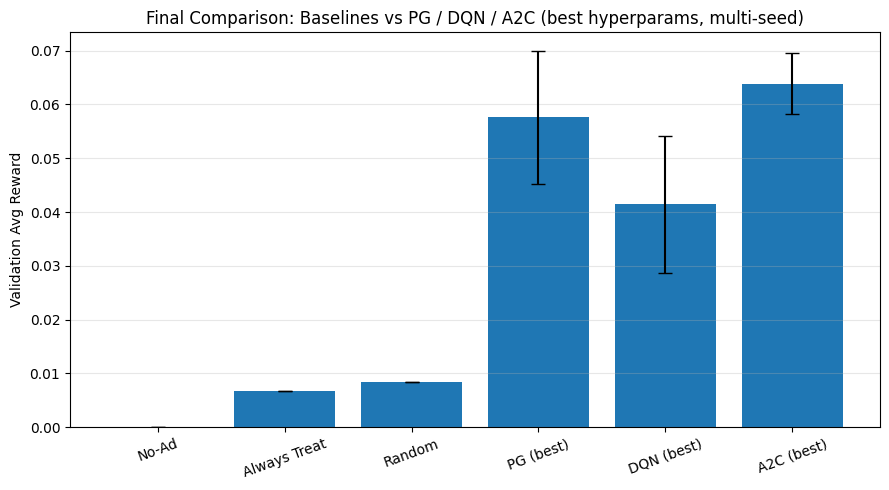

In [163]:
policies = ["No-Ad", "Always Treat", "Random", "PG (best)", "DQN (best)", "A2C (best)"]
means = [
    avg_no2,
    avg_all2,
    avg_rand2,
    pg_val_mean_best2,
    dqn_val_mean_best2,
    a2c_val_mean_best2,
]
stds = [
    0.0,
    0.0,
    0.0,
    pg_val_std_best2,
    dqn_val_std_best2,
    a2c_val_std_best2,
]

x = np.arange(len(policies))

plt.figure(figsize=(9,5))
plt.bar(x, means, yerr=stds, capsize=5)
plt.xticks(x, policies, rotation=20)
plt.ylabel("Validation Avg Reward")
plt.title("Final Comparison: Baselines vs PG / DQN / A2C (best hyperparams, multi-seed)")
plt.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.show()
